## Introduction:

The goal of this Project is to use data from different sensors to develop a smart smoke detector that avoids false positives that normal smoke detectors have by ai sensor fusion (collecting the information from multiple sensors before making the decision of weather there is a fire or not)

The Collection of the training data is performed with the help of IOT devices/sensors.

Many different environments and fire sources have to be sampled to ensure a good dataset for training. 

A short list of different scenarios which are captured:

1. Normal indoor
2. Normal outdoor
3. Indoor wood fire, firefighter training area
4. Indoor gas fire, firefighter training area
5. Outdoor wood, coal, and gas grill
5. Outdoor high humidity

## EDA:

Import the necessary libraries: 

In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")

Read the data into a panda dataframe

and show the first 5 rows

In [4]:
df=pd.read_csv("smoke_detection_iot.csv")
df.head()

Unnamed: 0         UTC  Temperature[C]  Humidity[%]  TVOC[ppb]  eCO2[ppm]  \
0           0  1654733331          20.000        57.36          0        400   
1           1  1654733332          20.015        56.67          0        400   
2           2  1654733333          20.029        55.96          0        400   
3           3  1654733334          20.044        55.28          0        400   
4           4  1654733335          20.059        54.69          0        400   

   Raw H2  Raw Ethanol  Pressure[hPa]  PM1.0  PM2.5  NC0.5  NC1.0  NC2.5  CNT  \
0   12306        18520        939.735    0.0    0.0    0.0    0.0    0.0    0   
1   12345        18651        939.744    0.0    0.0    0.0    0.0    0.0    1   
2   12374        18764        939.738    0.0    0.0    0.0    0.0    0.0    2   
3   12390        18849        939.736    0.0    0.0    0.0    0.0    0.0    3   
4   12403        18921        939.744    0.0    0.0    0.0    0.0    0.0    4   

   Fire Alarm  
0           0  
1           0  
2           0  
3           0  
4           0

Features Meanings:

1- UTC : Timestamp UTC seconds

2- Temperature : Air Temperature

3- Humidity : Air Humidity

4- TVOC : Total Volatile Organic Compounds; measured in parts per billion

5- eCo2 : C02 equivalent concentration; calculated from different values like TVCO

6- Raw H2 : Raw molecular hydrogen; not compensated (Bias, temperature, etc.)

7- Raw Ethanol : Raw ethanol gas

8- Pressure : Air Pressure

9- PM1.0 : Particulate matter size < 1.0 µm (PM1.0)

10- PM2.5 : Particulate matter size < 2.5 µm (PM2.5)

11- NC0.5 : Concentration of particulate matter of diameter less than 0.5 micrometers.

12- NC1.0 : Concentration of particulate matter of diameter less than 1.0 micrometers.

13- NC2.5 : Concentration of particulate matter of diameter less than 2.5 micrometers.

14- CNT: Sample counter

15- Fire Alarm: ground truth is "1" if a fire is there. The Target

Rename some Columns with easier to type names

In [5]:
df = df.rename(columns={'Pressure[hPa]':'Pressure'
                        , 'Temperature[C]':'Temperature'
                        , 'Humidity[%]': 'Humidity'
                        , 'TVOC[ppb]': 'TVOC'
                        , 'eCO2[ppm]': 'ECO2' })

Drop the unnecessary columns

In [6]:
df = df.drop('Unnamed: 0', axis= 1)
df = df.drop('UTC', axis = 1)
df = df.drop('CNT', axis = 1)

In [7]:
df.head()

Temperature  Humidity  TVOC  ECO2  Raw H2  Raw Ethanol  Pressure  PM1.0  \
0       20.000     57.36     0   400   12306        18520   939.735    0.0   
1       20.015     56.67     0   400   12345        18651   939.744    0.0   
2       20.029     55.96     0   400   12374        18764   939.738    0.0   
3       20.044     55.28     0   400   12390        18849   939.736    0.0   
4       20.059     54.69     0   400   12403        18921   939.744    0.0   

   PM2.5  NC0.5  NC1.0  NC2.5  Fire Alarm  
0    0.0    0.0    0.0    0.0           0  
1    0.0    0.0    0.0    0.0           0  
2    0.0    0.0    0.0    0.0           0  
3    0.0    0.0    0.0    0.0           0  
4    0.0    0.0    0.0    0.0           0

Get info about the null count and Type of the features in the dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  62630 non-null  float64
 1   Humidity     62630 non-null  float64
 2   TVOC         62630 non-null  int64  
 3   ECO2         62630 non-null  int64  
 4   Raw H2       62630 non-null  int64  
 5   Raw Ethanol  62630 non-null  int64  
 6   Pressure     62630 non-null  float64
 7   PM1.0        62630 non-null  float64
 8   PM2.5        62630 non-null  float64
 9   NC0.5        62630 non-null  float64
 10  NC1.0        62630 non-null  float64
 11  NC2.5        62630 non-null  float64
 12  Fire Alarm   62630 non-null  int64  
dtypes: float64(8), int64(5)
memory usage: 6.2 MB


Get mathematical info about the data such as mean, standard deviation, min, max & more 

In [9]:
df.describe()

Temperature      Humidity          TVOC          ECO2        Raw H2  \
count  62630.000000  62630.000000  62630.000000  62630.000000  62630.000000   
mean      15.970424     48.539499   1942.057528    670.021044  12942.453936   
std       14.359576      8.865367   7811.589055   1905.885439    272.464305   
min      -22.010000     10.740000      0.000000    400.000000  10668.000000   
25%       10.994250     47.530000    130.000000    400.000000  12830.000000   
50%       20.130000     50.150000    981.000000    400.000000  12924.000000   
75%       25.409500     53.240000   1189.000000    438.000000  13109.000000   
max       59.930000     75.200000  60000.000000  60000.000000  13803.000000   

        Raw Ethanol      Pressure         PM1.0         PM2.5         NC0.5  \
count  62630.000000  62630.000000  62630.000000  62630.000000  62630.000000   
mean   19754.257912    938.627649    100.594309    184.467770    491.463608   
std      609.513156      1.331344    922.524245   1976.305615   4265.661251   
min    15317.000000    930.852000      0.000000      0.000000      0.000000   
25%    19435.000000    938.700000      1.280000      1.340000      8.820000   
50%    19501.000000    938.816000      1.810000      1.880000     12.450000   
75%    20078.000000    939.418000      2.090000      2.180000     14.420000   
max    21410.000000    939.861000  14333.690000  45432.260000  61482.030000   

              NC1.0         NC2.5    Fire Alarm  
count  62630.000000  62630.000000  62630.000000  
mean     203.586487     80.049042      0.714626  
std     2214.738556   1083.383189      0.451596  
min        0.000000      0.000000      0.000000  
25%        1.384000      0.033000      0.000000  
50%        1.943000      0.044000      1.000000  
75%        2.249000      0.051000      1.000000  
max    51914.680000  30026.438000      1.000000

get the number of unique values in each feature

In [10]:
df.nunique()

Temperature    21672
Humidity        3890
TVOC            1966
ECO2            1713
Raw H2          1830
Raw Ethanol     2659
Pressure        2213
PM1.0           1337
PM2.5           1351
NC0.5           3093
NC1.0           4113
NC2.5           1161
Fire Alarm         2
dtype: int64

get the number of nulls in each feature

In [11]:
df.isnull().sum()

Temperature    0
Humidity       0
TVOC           0
ECO2           0
Raw H2         0
Raw Ethanol    0
Pressure       0
PM1.0          0
PM2.5          0
NC0.5          0
NC1.0          0
NC2.5          0
Fire Alarm     0
dtype: int64

In [12]:
df.isna().sum()

Temperature    0
Humidity       0
TVOC           0
ECO2           0
Raw H2         0
Raw Ethanol    0
Pressure       0
PM1.0          0
PM2.5          0
NC0.5          0
NC1.0          0
NC2.5          0
Fire Alarm     0
dtype: int64

get the number of duplicated rows

In [13]:
df.duplicated().sum()

2

remove the duplicates

In [14]:
df = df.drop_duplicates()

recheck the duplicates to make sure they were dropped successfullly 

In [15]:
df.duplicated().sum()

0

In [16]:
df.dtypes

Temperature    float64
Humidity       float64
TVOC             int64
ECO2             int64
Raw H2           int64
Raw Ethanol      int64
Pressure       float64
PM1.0          float64
PM2.5          float64
NC0.5          float64
NC1.0          float64
NC2.5          float64
Fire Alarm       int64
dtype: object

check the row x columns of the dataset

In [17]:
df.shape

(62628, 13)

Check the first five rows of the dataset

In [18]:
df.head()

Temperature  Humidity  TVOC  ECO2  Raw H2  Raw Ethanol  Pressure  PM1.0  \
0       20.000     57.36     0   400   12306        18520   939.735    0.0   
1       20.015     56.67     0   400   12345        18651   939.744    0.0   
2       20.029     55.96     0   400   12374        18764   939.738    0.0   
3       20.044     55.28     0   400   12390        18849   939.736    0.0   
4       20.059     54.69     0   400   12403        18921   939.744    0.0   

   PM2.5  NC0.5  NC1.0  NC2.5  Fire Alarm  
0    0.0    0.0    0.0    0.0           0  
1    0.0    0.0    0.0    0.0           0  
2    0.0    0.0    0.0    0.0           0  
3    0.0    0.0    0.0    0.0           0  
4    0.0    0.0    0.0    0.0           0

In [19]:
df.describe()

Temperature      Humidity          TVOC          ECO2        Raw H2  \
count  62628.000000  62628.000000  62628.000000  62628.000000  62628.000000   
mean      15.970071     48.539618   1942.118318    670.029236  12942.457240   
std       14.359670      8.865484   7811.706379   1905.915320    272.468026   
min      -22.010000     10.740000      0.000000    400.000000  10668.000000   
25%       10.994000     47.530000    130.000000    400.000000  12830.000000   
50%       20.130000     50.150000    981.000000    400.000000  12924.000000   
75%       25.407250     53.240000   1189.000000    438.000000  13109.000000   
max       59.930000     75.200000  60000.000000  60000.000000  13803.000000   

        Raw Ethanol      Pressure         PM1.0         PM2.5         NC0.5  \
count  62628.000000  62628.000000  62628.000000  62628.000000  62628.000000   
mean   19754.226480    938.627683    100.597455    184.473592    491.478842   
std      609.497498      1.331352    922.538807   1976.336903   4265.728511   
min    15317.000000    930.852000      0.000000      0.000000      0.000000   
25%    19435.000000    938.700000      1.280000      1.340000      8.820000   
50%    19501.000000    938.816000      1.810000      1.880000     12.450000   
75%    20078.000000    939.418000      2.090000      2.180000     14.420000   
max    21410.000000    939.861000  14333.690000  45432.260000  61482.030000   

              NC1.0         NC2.5    Fire Alarm  
count  62628.000000  62628.000000  62628.000000  
mean     203.592917     80.051597      0.714648  
std     2214.773627   1083.400393      0.451585  
min        0.000000      0.000000      0.000000  
25%        1.384000      0.033000      0.000000  
50%        1.943000      0.044000      1.000000  
75%        2.249000      0.051000      1.000000  
max    51914.680000  30026.438000      1.000000

we notice that there are some features that have outliers (a huge jump between 75% and max) like TVOC, ECO2, PM1.0, PM2.5, NC0.5, NC1.0, NC2.5

### Data Visualization:

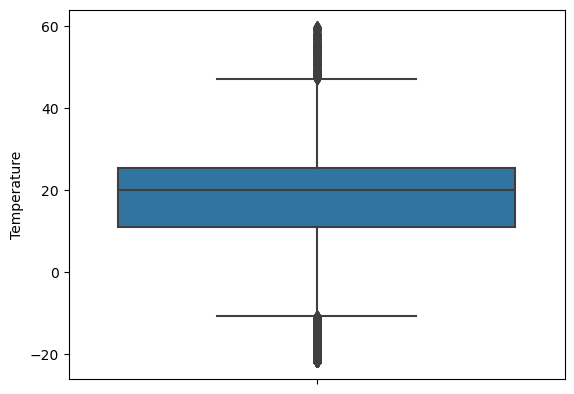

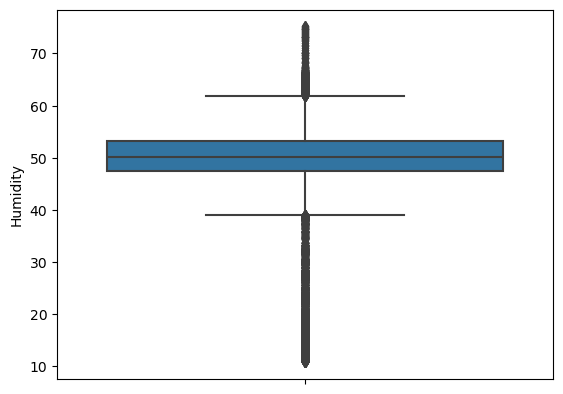

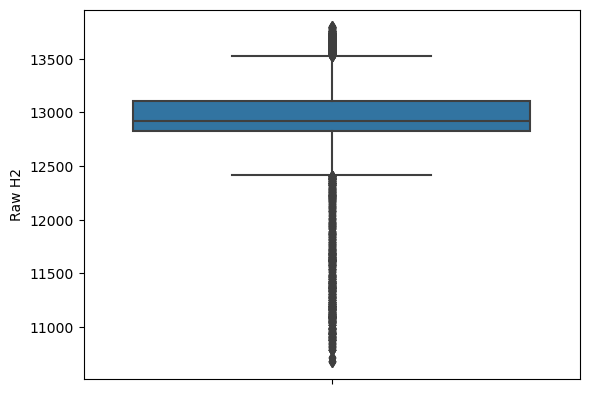

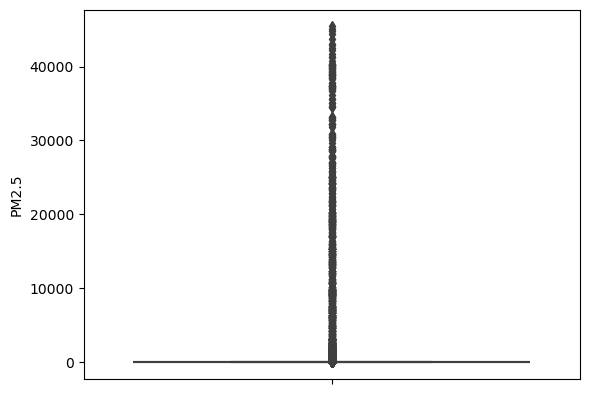

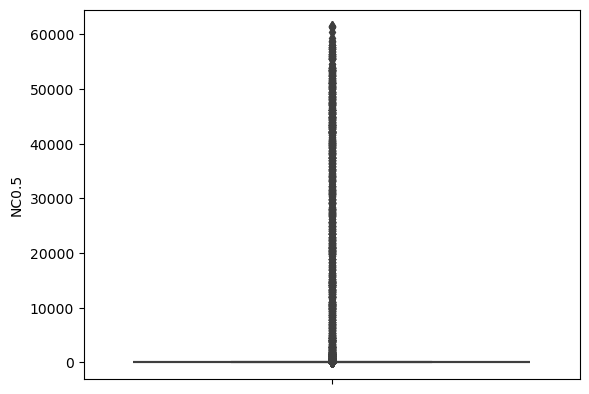

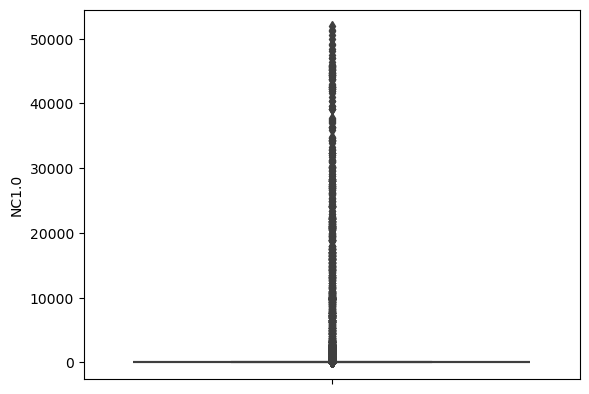

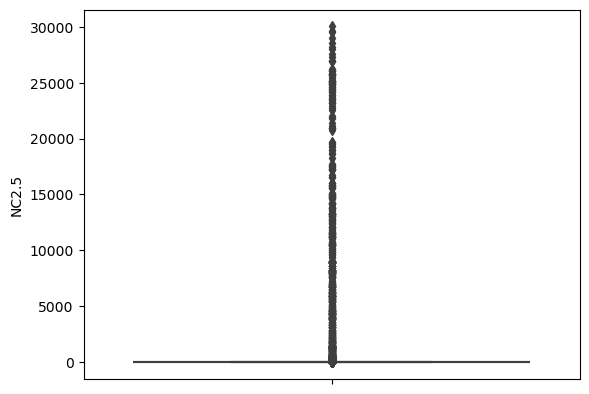

In [20]:
for x in df.columns.drop('Fire Alarm'): # to check the outliers of the data
        sns.boxplot(y=df[x])
        plt.show()

we can see outliers in almost all features which we need to treat

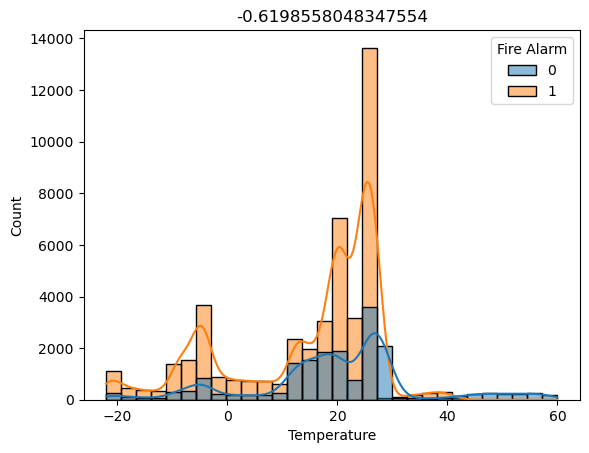

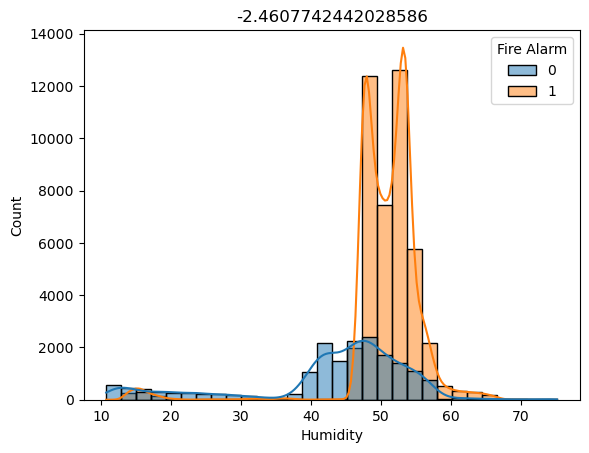

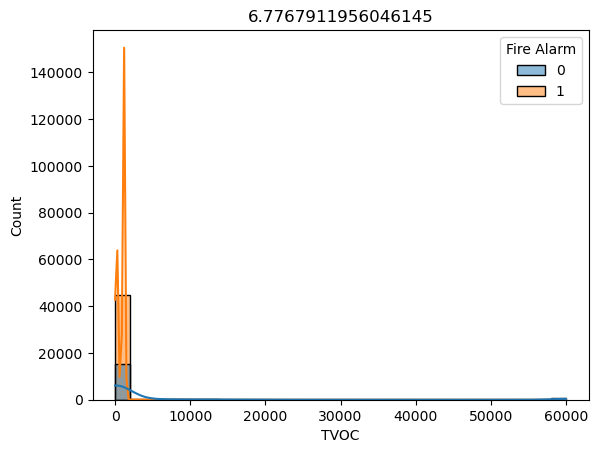

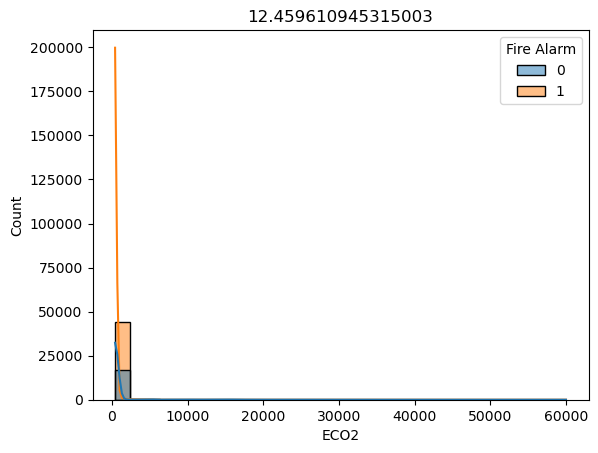

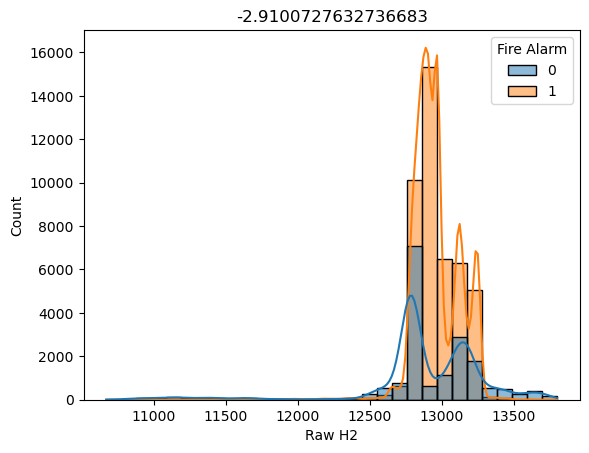

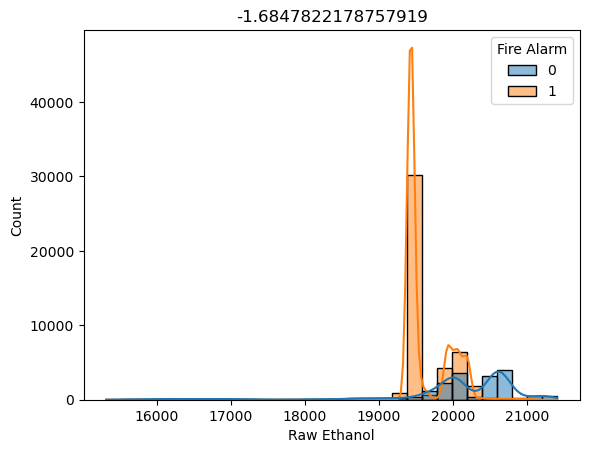

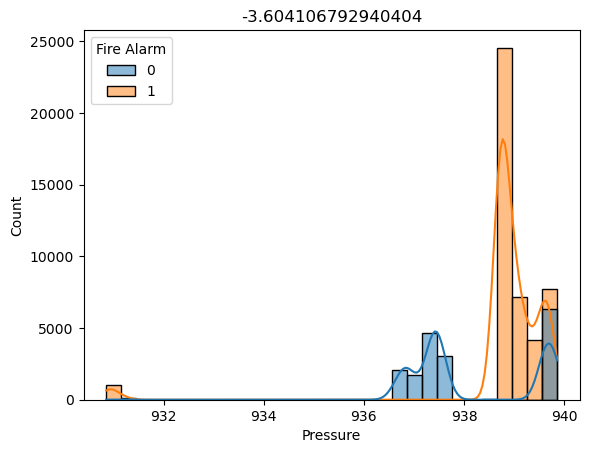

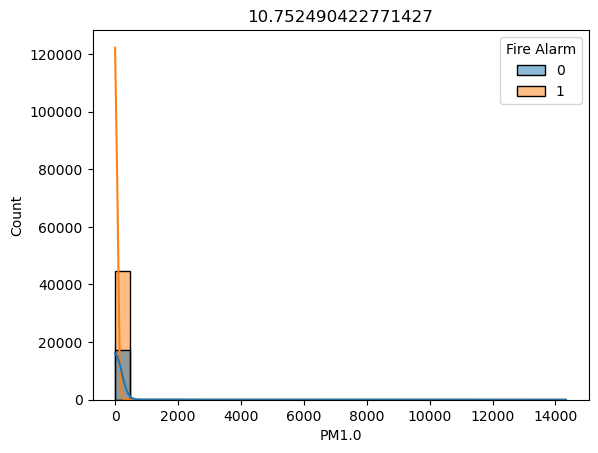

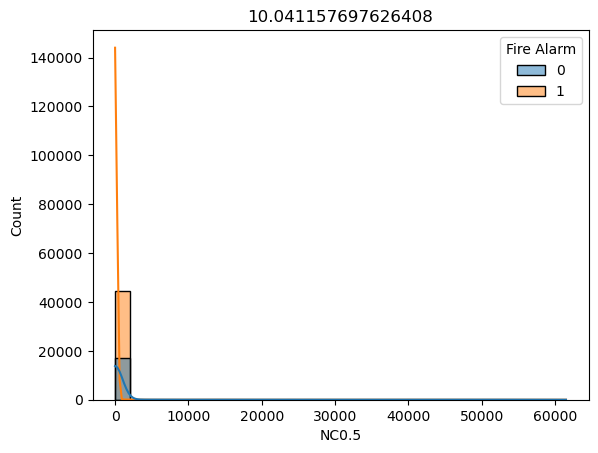

In [21]:
for x in df.columns.drop('Fire Alarm'): # to check the relation between the features and fire alarm and the skewness
        sns.histplot(data=df, x=df[x], bins=30, hue='Fire Alarm', kde=True)
        plt.title(df[x].skew())
        plt.show()

we can see that all of them are very highly skewed we will check on the again after the outlier treatment

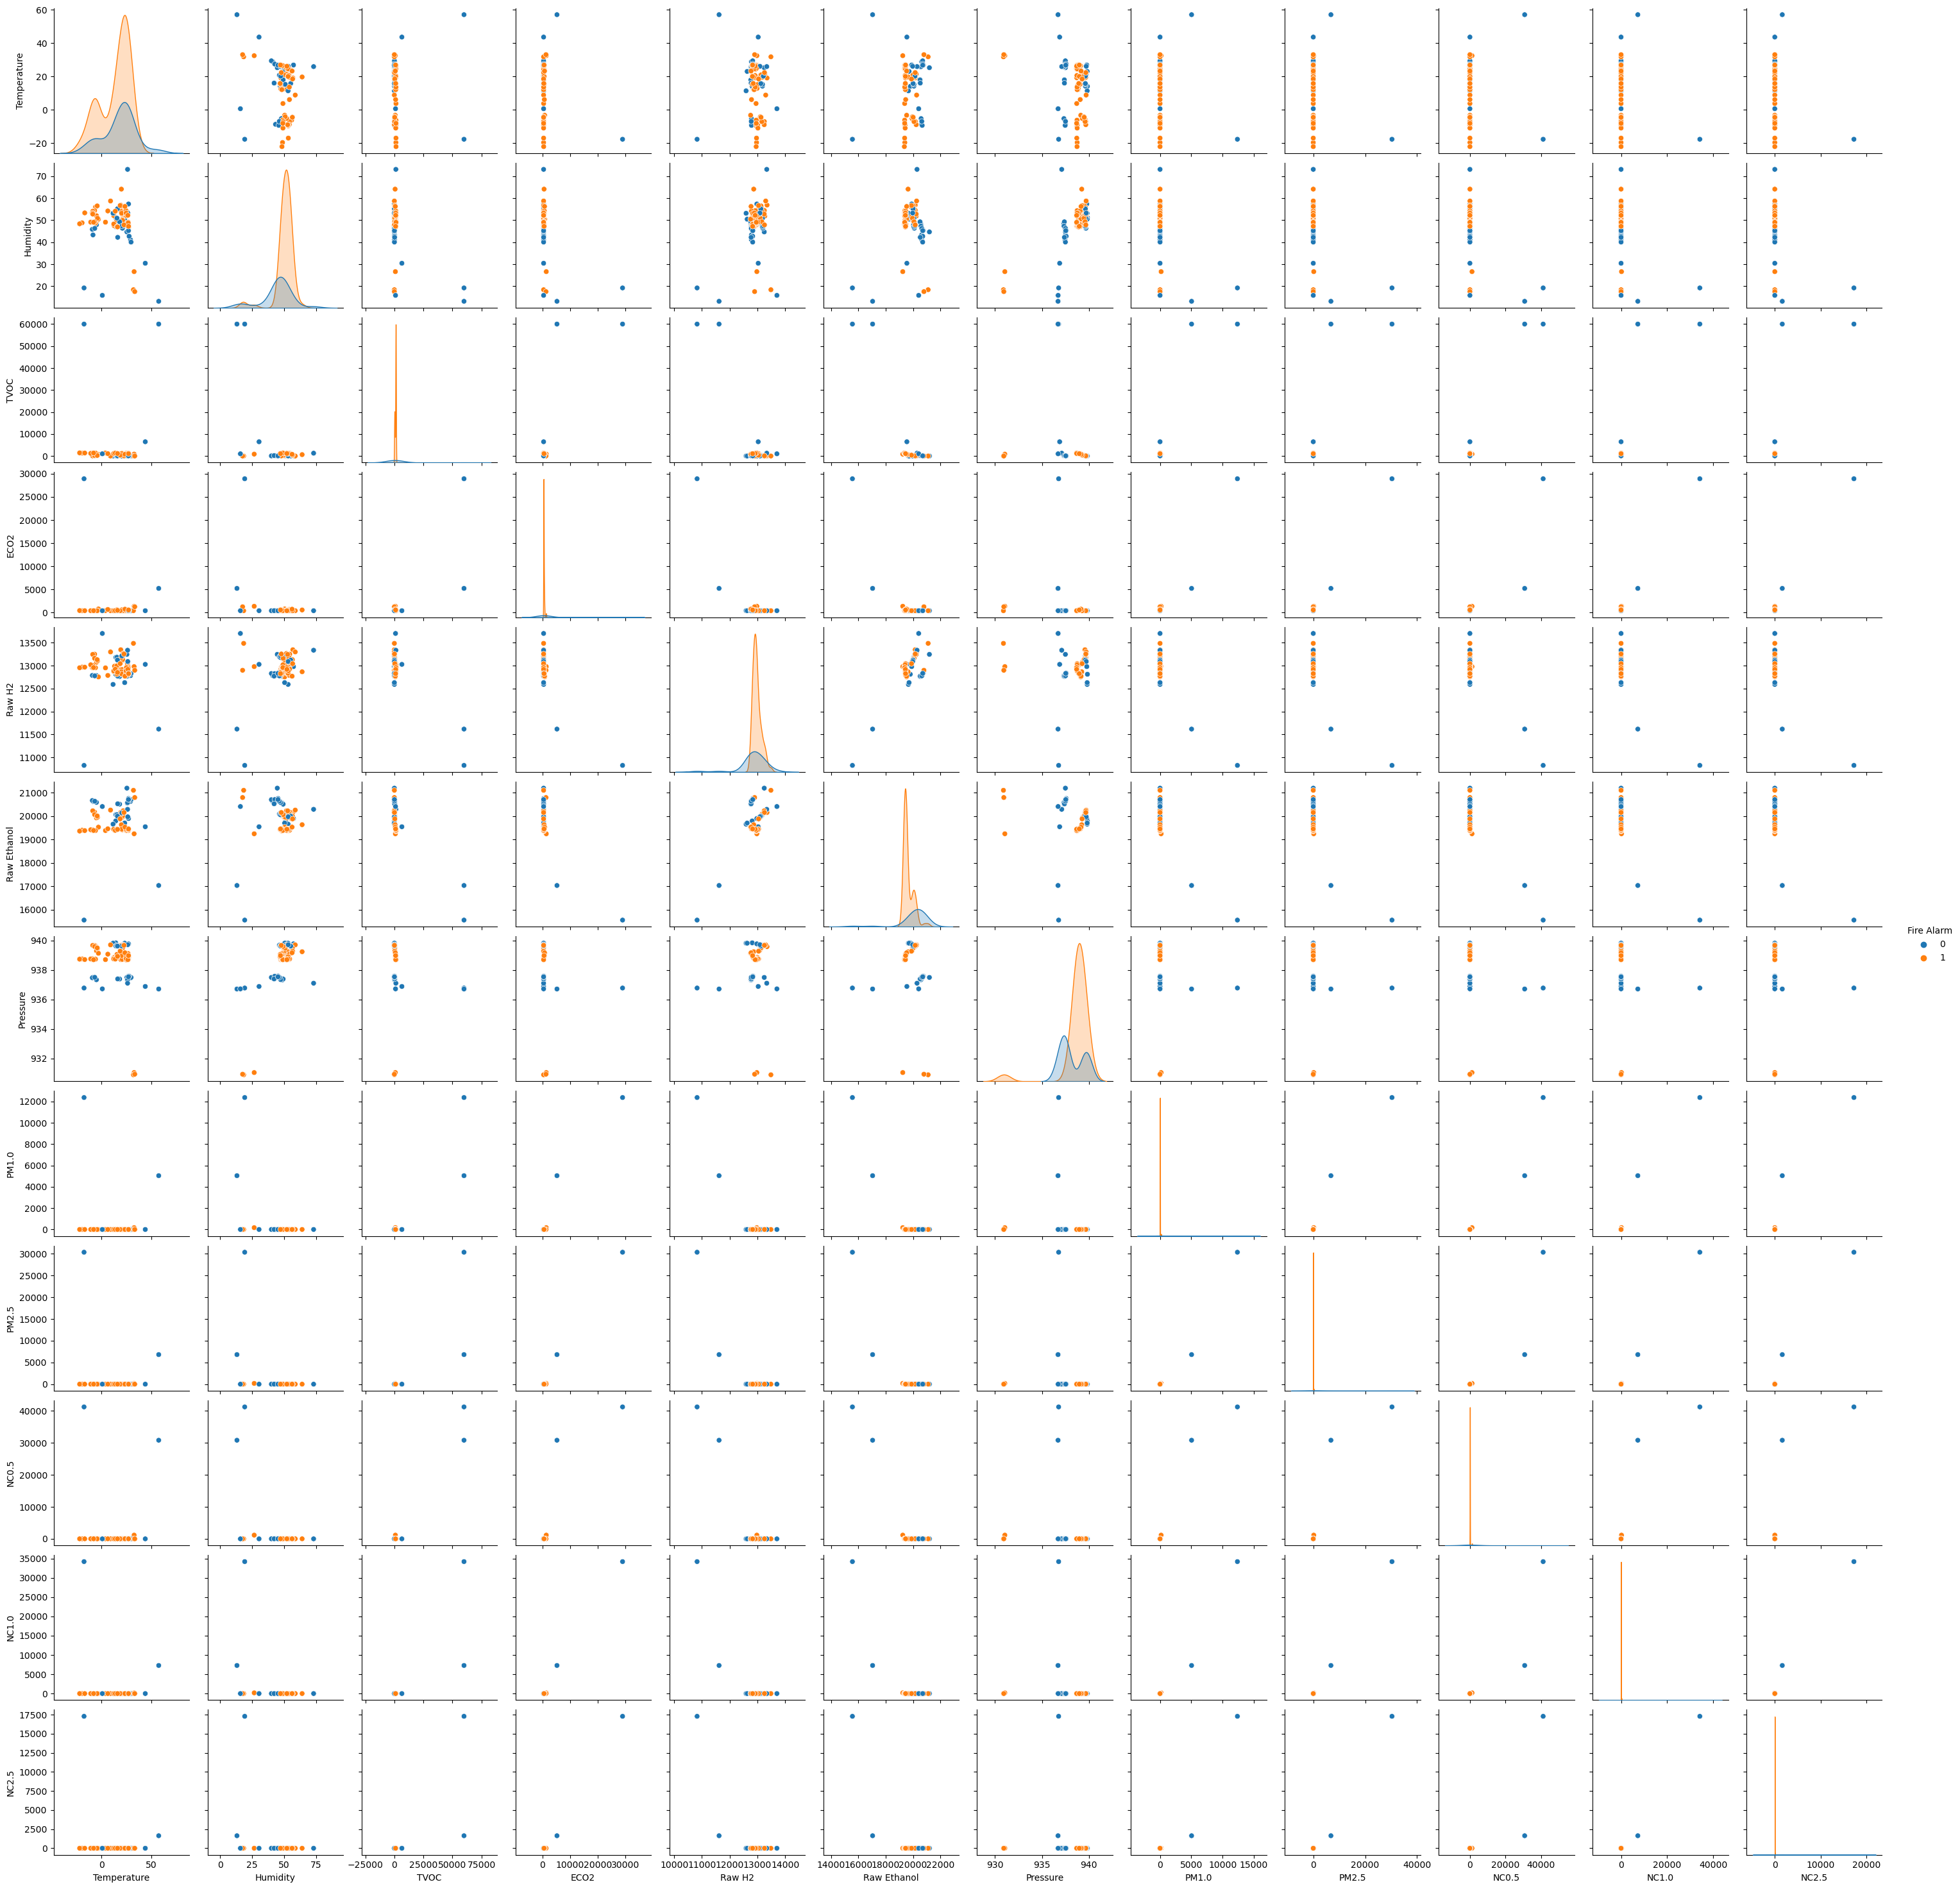

In [22]:
sns.pairplot(data=df.sample(100), hue="Fire Alarm")

## Outlier Treatment:

here we fix the outliers using the IQR method

In [23]:
fixed=[]
for i in df:
    Q1 = df[i].quantile(.25)
    Q3 = df[i].quantile(.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5* IQR
    upper_bound = Q3 + 1.5* IQR
    fixed.append((lower_bound, upper_bound))
    
df_new= df.copy()
for feature, value in zip(df, fixed):
    lower_bound, upper_bound = value
    df_new[feature] = np.where(df[feature] > upper_bound, upper_bound,
        np.where(df[feature] < lower_bound, lower_bound, df[feature]))

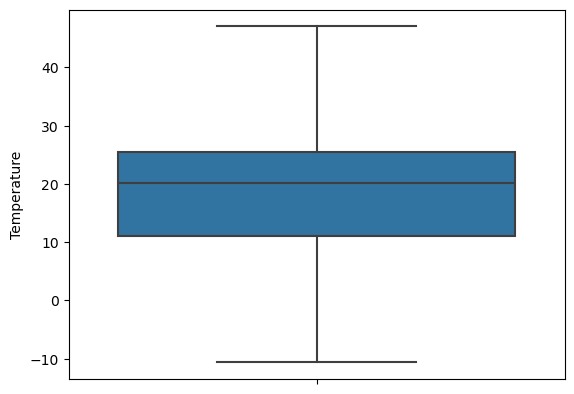

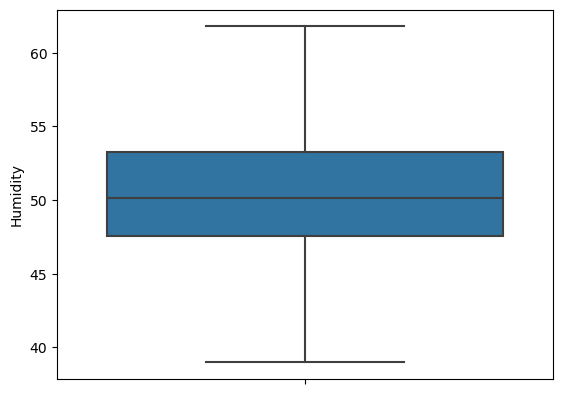

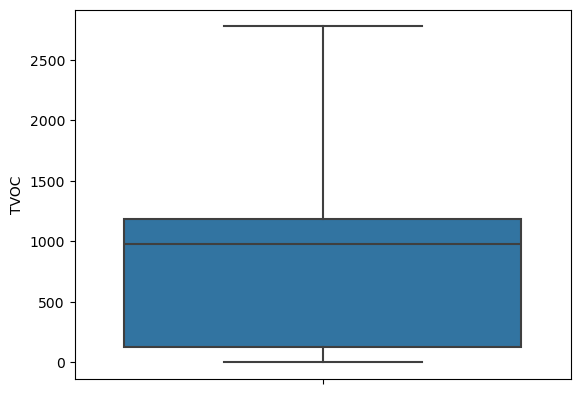

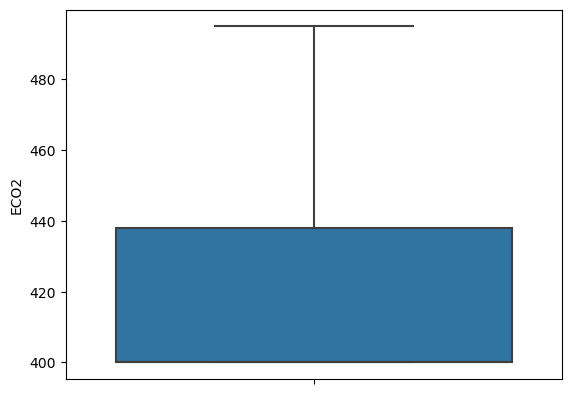

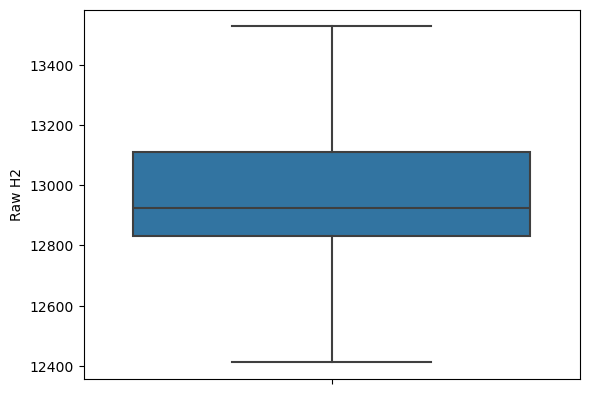

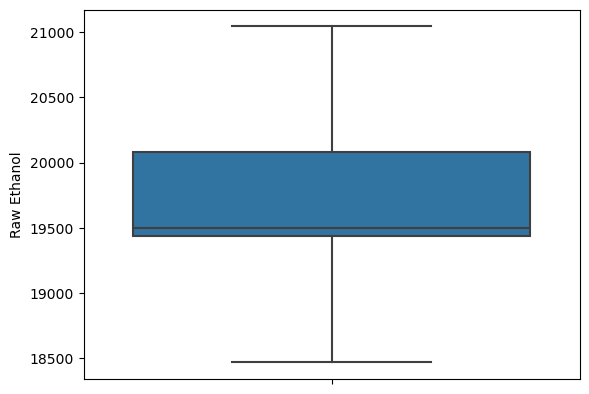

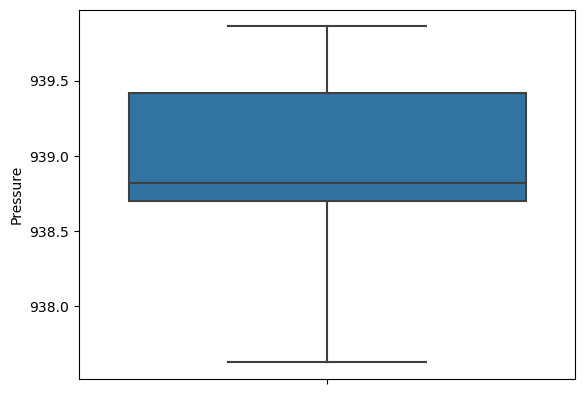

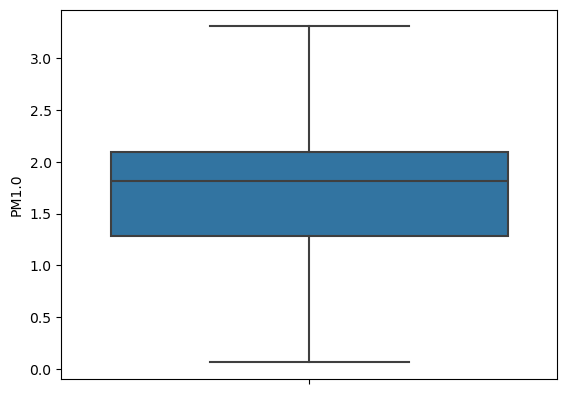

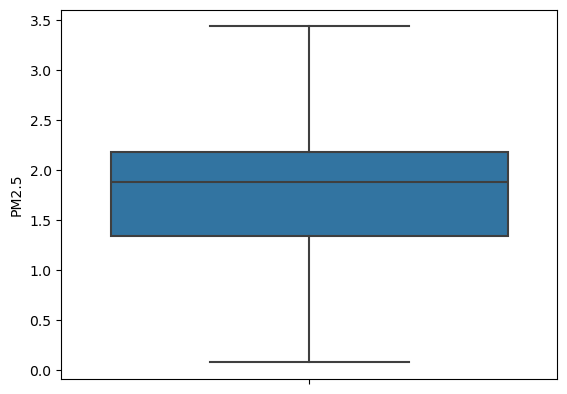

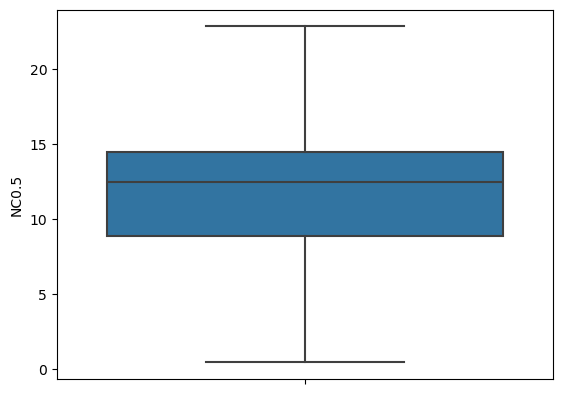

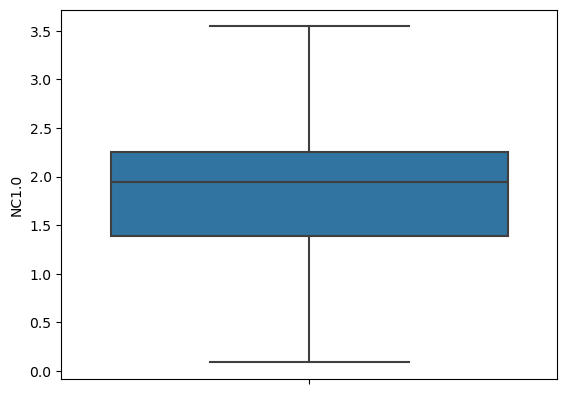

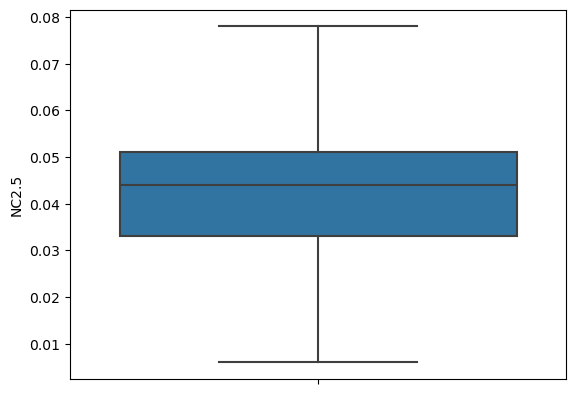

In [24]:
for x in df_new.columns.drop('Fire Alarm'): # to check the outliers after treatment
        sns.boxplot(y=x,data=df_new)
        plt.show()

In [25]:
df.describe()

Temperature      Humidity          TVOC          ECO2        Raw H2  \
count  62628.000000  62628.000000  62628.000000  62628.000000  62628.000000   
mean      15.970071     48.539618   1942.118318    670.029236  12942.457240   
std       14.359670      8.865484   7811.706379   1905.915320    272.468026   
min      -22.010000     10.740000      0.000000    400.000000  10668.000000   
25%       10.994000     47.530000    130.000000    400.000000  12830.000000   
50%       20.130000     50.150000    981.000000    400.000000  12924.000000   
75%       25.407250     53.240000   1189.000000    438.000000  13109.000000   
max       59.930000     75.200000  60000.000000  60000.000000  13803.000000   

        Raw Ethanol      Pressure         PM1.0         PM2.5         NC0.5  \
count  62628.000000  62628.000000  62628.000000  62628.000000  62628.000000   
mean   19754.226480    938.627683    100.597455    184.473592    491.478842   
std      609.497498      1.331352    922.538807   1976.336903   4265.728511   
min    15317.000000    930.852000      0.000000      0.000000      0.000000   
25%    19435.000000    938.700000      1.280000      1.340000      8.820000   
50%    19501.000000    938.816000      1.810000      1.880000     12.450000   
75%    20078.000000    939.418000      2.090000      2.180000     14.420000   
max    21410.000000    939.861000  14333.690000  45432.260000  61482.030000   

              NC1.0         NC2.5    Fire Alarm  
count  62628.000000  62628.000000  62628.000000  
mean     203.592917     80.051597      0.714648  
std     2214.773627   1083.400393      0.451585  
min        0.000000      0.000000      0.000000  
25%        1.384000      0.033000      0.000000  
50%        1.943000      0.044000      1.000000  
75%        2.249000      0.051000      1.000000  
max    51914.680000  30026.438000      1.000000

In [26]:
df_new.describe()

Temperature      Humidity          TVOC          ECO2        Raw H2  \
count  62628.000000  62628.000000  62628.000000  62628.000000  62628.000000   
mean      16.206105     49.773316    773.299427    425.175097  12957.087780   
std       13.315112      4.902856    669.556480     37.461026    193.029651   
min      -10.625875     38.965000      0.000000    400.000000  12411.500000   
25%       10.994000     47.530000    130.000000    400.000000  12830.000000   
50%       20.130000     50.150000    981.000000    400.000000  12924.000000   
75%       25.407250     53.240000   1189.000000    438.000000  13109.000000   
max       47.027125     61.805000   2777.500000    495.000000  13527.500000   

        Raw Ethanol      Pressure         PM1.0         PM2.5         NC0.5  \
count  62628.000000  62628.000000  62628.000000  62628.000000  62628.000000   
mean   19778.011536    938.820697      1.650174      1.717014     11.354405   
std      489.441462      0.700175      0.715805      0.741759      4.939729   
min    18470.500000    937.623000      0.065000      0.080000      0.420000   
25%    19435.000000    938.700000      1.280000      1.340000      8.820000   
50%    19501.000000    938.816000      1.810000      1.880000     12.450000   
75%    20078.000000    939.418000      2.090000      2.180000     14.420000   
max    21042.500000    939.861000      3.305000      3.440000     22.820000   

              NC1.0         NC2.5    Fire Alarm  
count  62628.000000  62628.000000  62628.000000  
mean       1.773878      0.040639      0.714648  
std        0.765607      0.016877      0.451585  
min        0.086500      0.006000      0.000000  
25%        1.384000      0.033000      0.000000  
50%        1.943000      0.044000      1.000000  
75%        2.249000      0.051000      1.000000  
max        3.546500      0.078000      1.000000

In [27]:
df = df_new

### Data Visualization After outlier treatment:

Plot a countplot for the Fire Alarm to see how many times it was triggered or not

<Axes: xlabel='Fire Alarm', ylabel='count'>

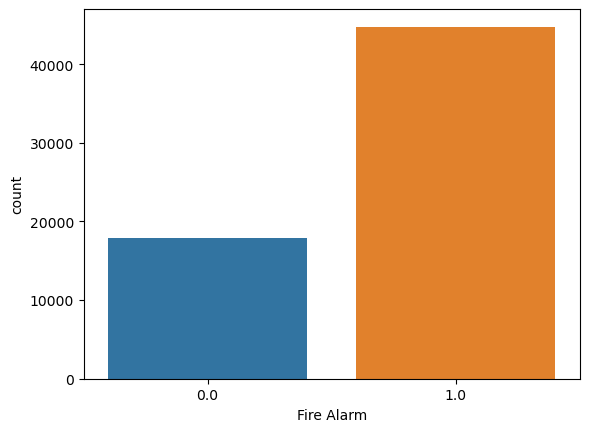

In [28]:
sns.countplot(data=df, x = "Fire Alarm")

we notice that the data is imbalanced as there are more than double fire alarm 1 than 0.

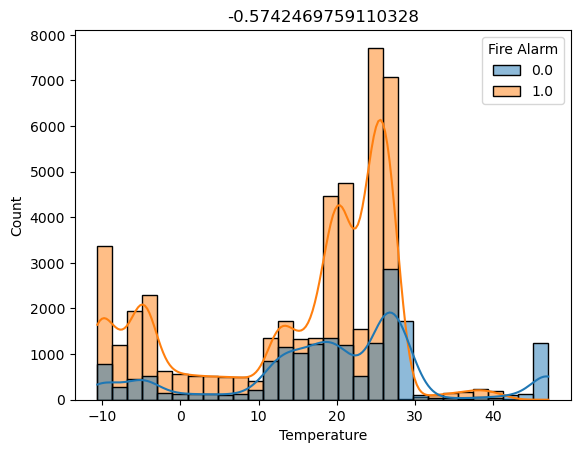

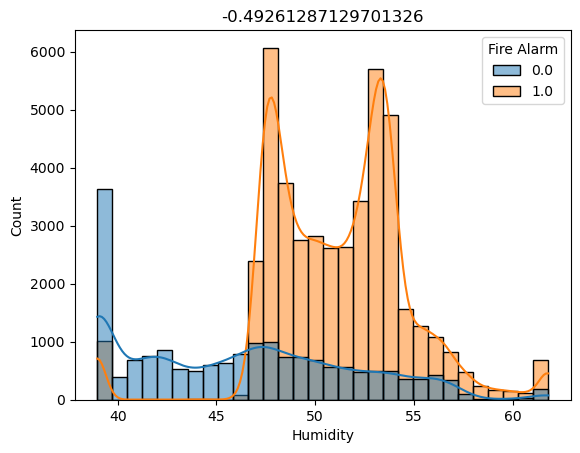

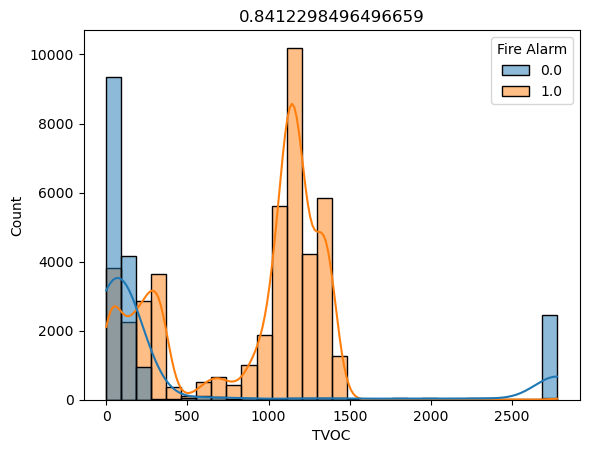

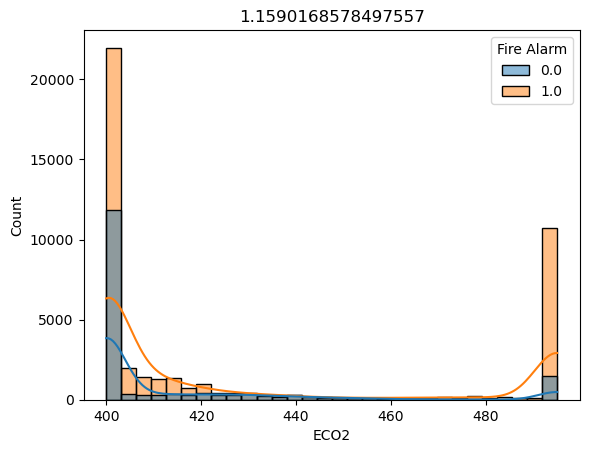

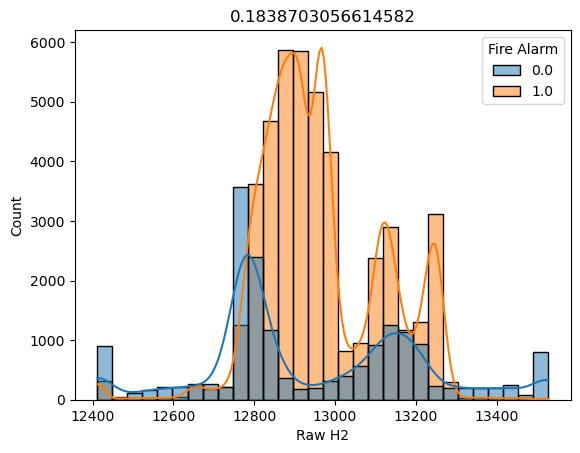

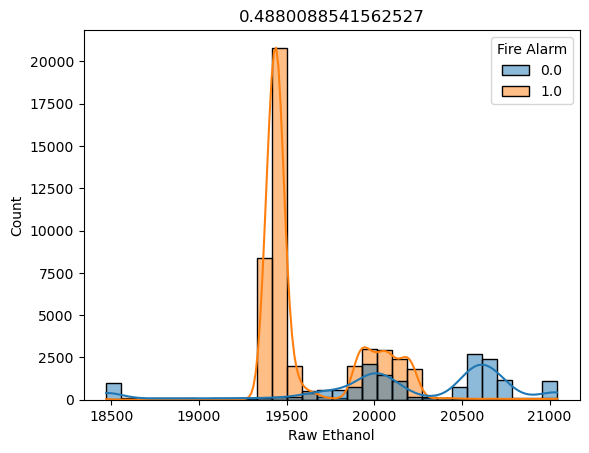

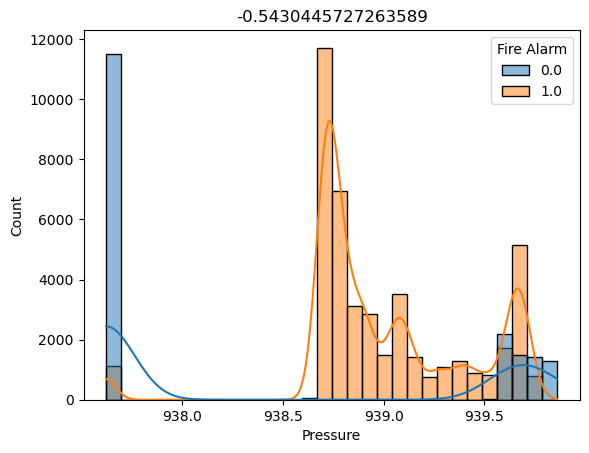

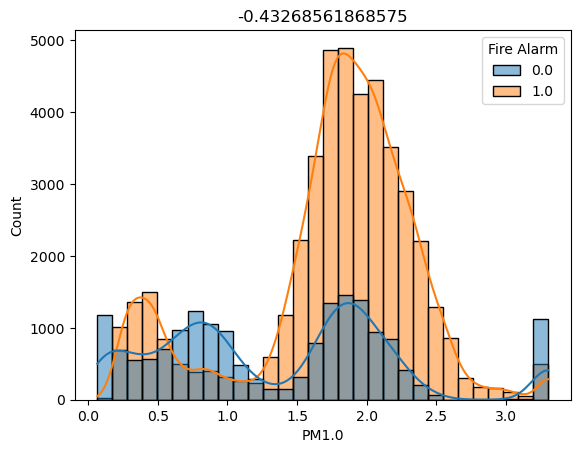

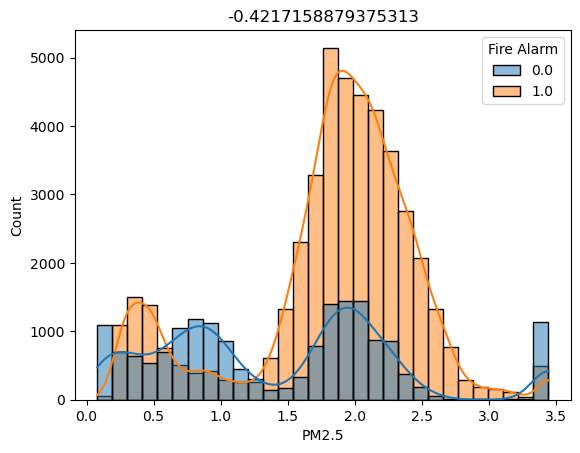

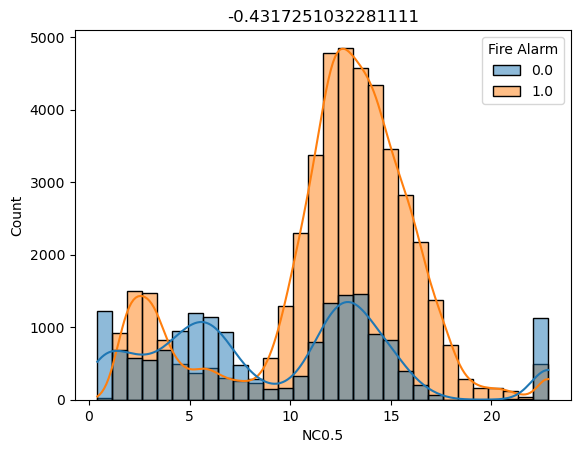

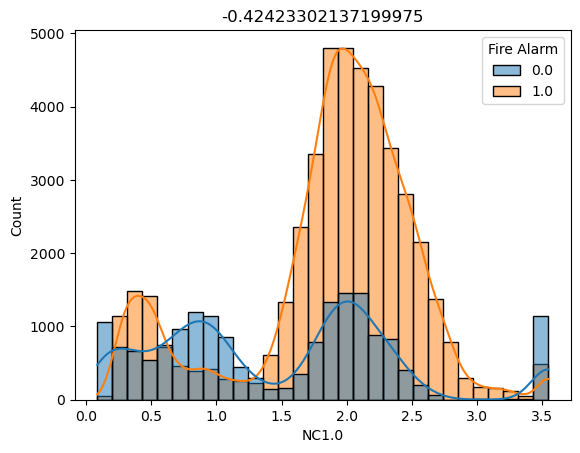

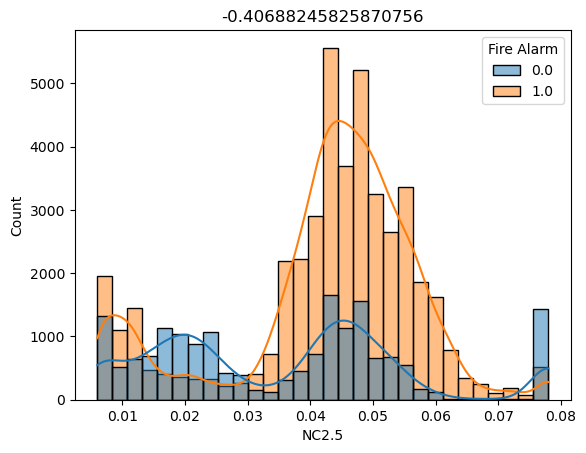

In [29]:
for x in df.columns.drop('Fire Alarm'): # to check the relation between the features and fire alarm and the skewness
        sns.histplot(data=df, x=df[x], bins=30, hue='Fire Alarm', kde=True)
        plt.title(df[x].skew())
        plt.show()

we can see that all of them are in the range of -0.5 <-> 0.5 which is ok but EC02 is high so we need to normalize it.

 Log Transformation of ECO2:

In [30]:
df['log ECO2'] = np.log(df['ECO2'])
print("The skewness of the original data is {}".format(df.ECO2.skew()))
print("The skewness of the LOG transformed data is {}".format(df['log ECO2'].skew()))


The skewness of the original data is 1.1590168578497557
The skewness of the LOG transformed data is 1.1306399838138843


In [31]:
df['ECO2'] = df['log ECO2']
df.drop(['log ECO2'], axis=1, inplace=True)

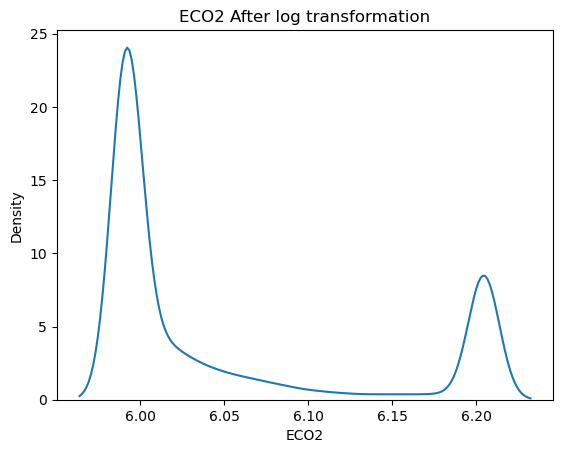

In [32]:
sns.kdeplot(df['ECO2'])
plt.title("ECO2 After log transformation")
plt.show()

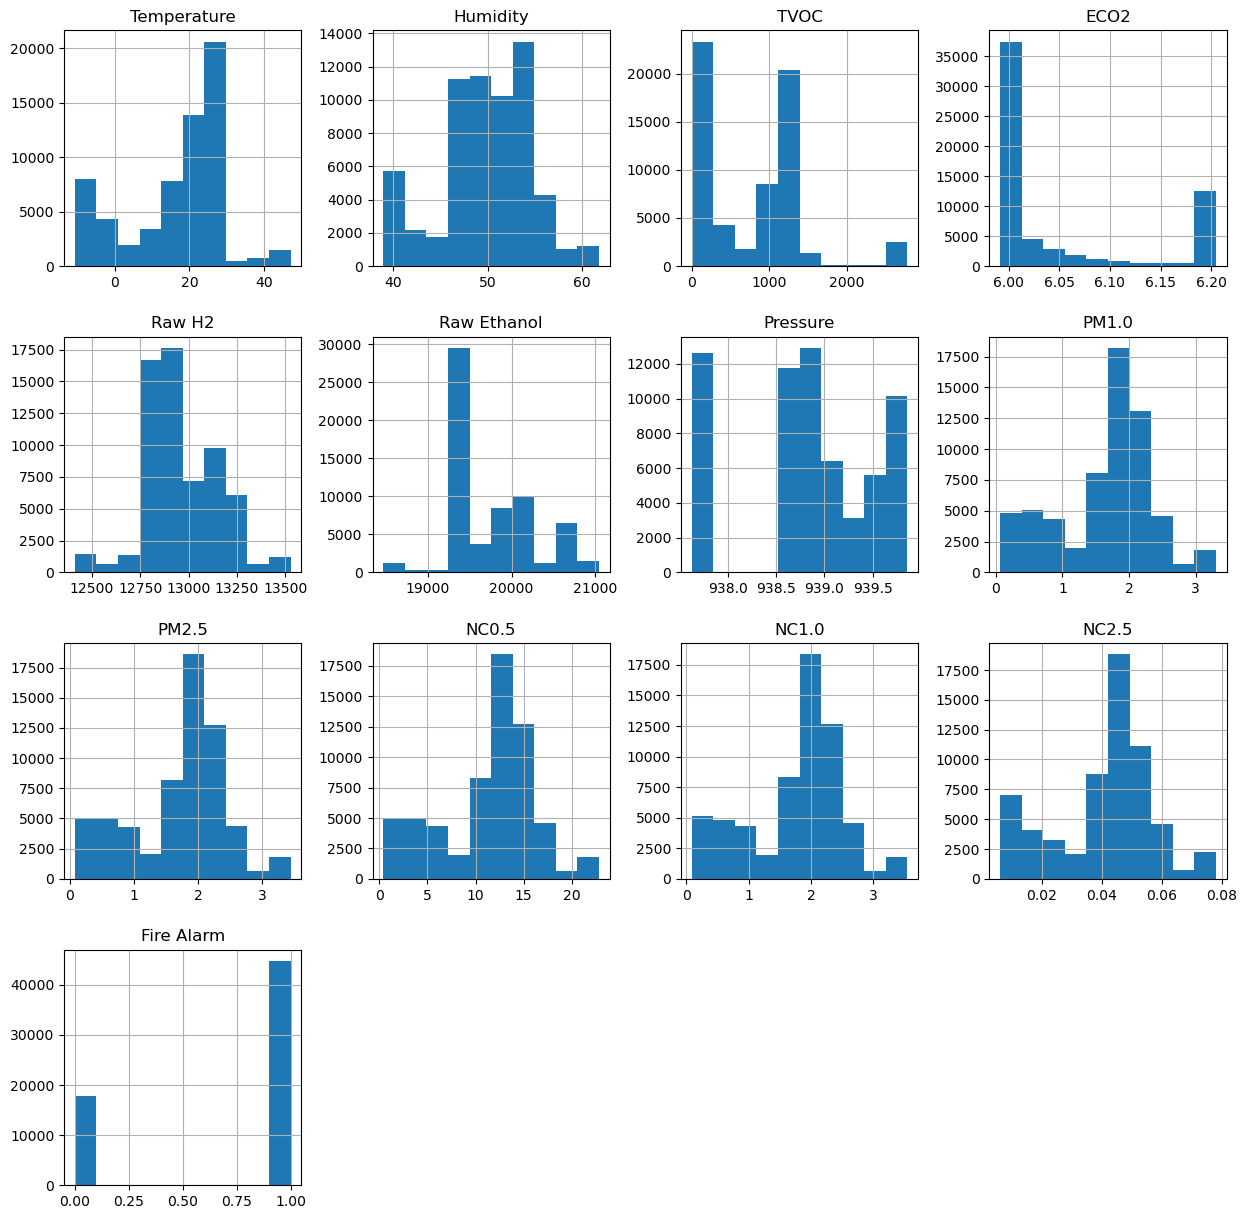

In [33]:
df.hist(figsize=(15,15))
plt.show()

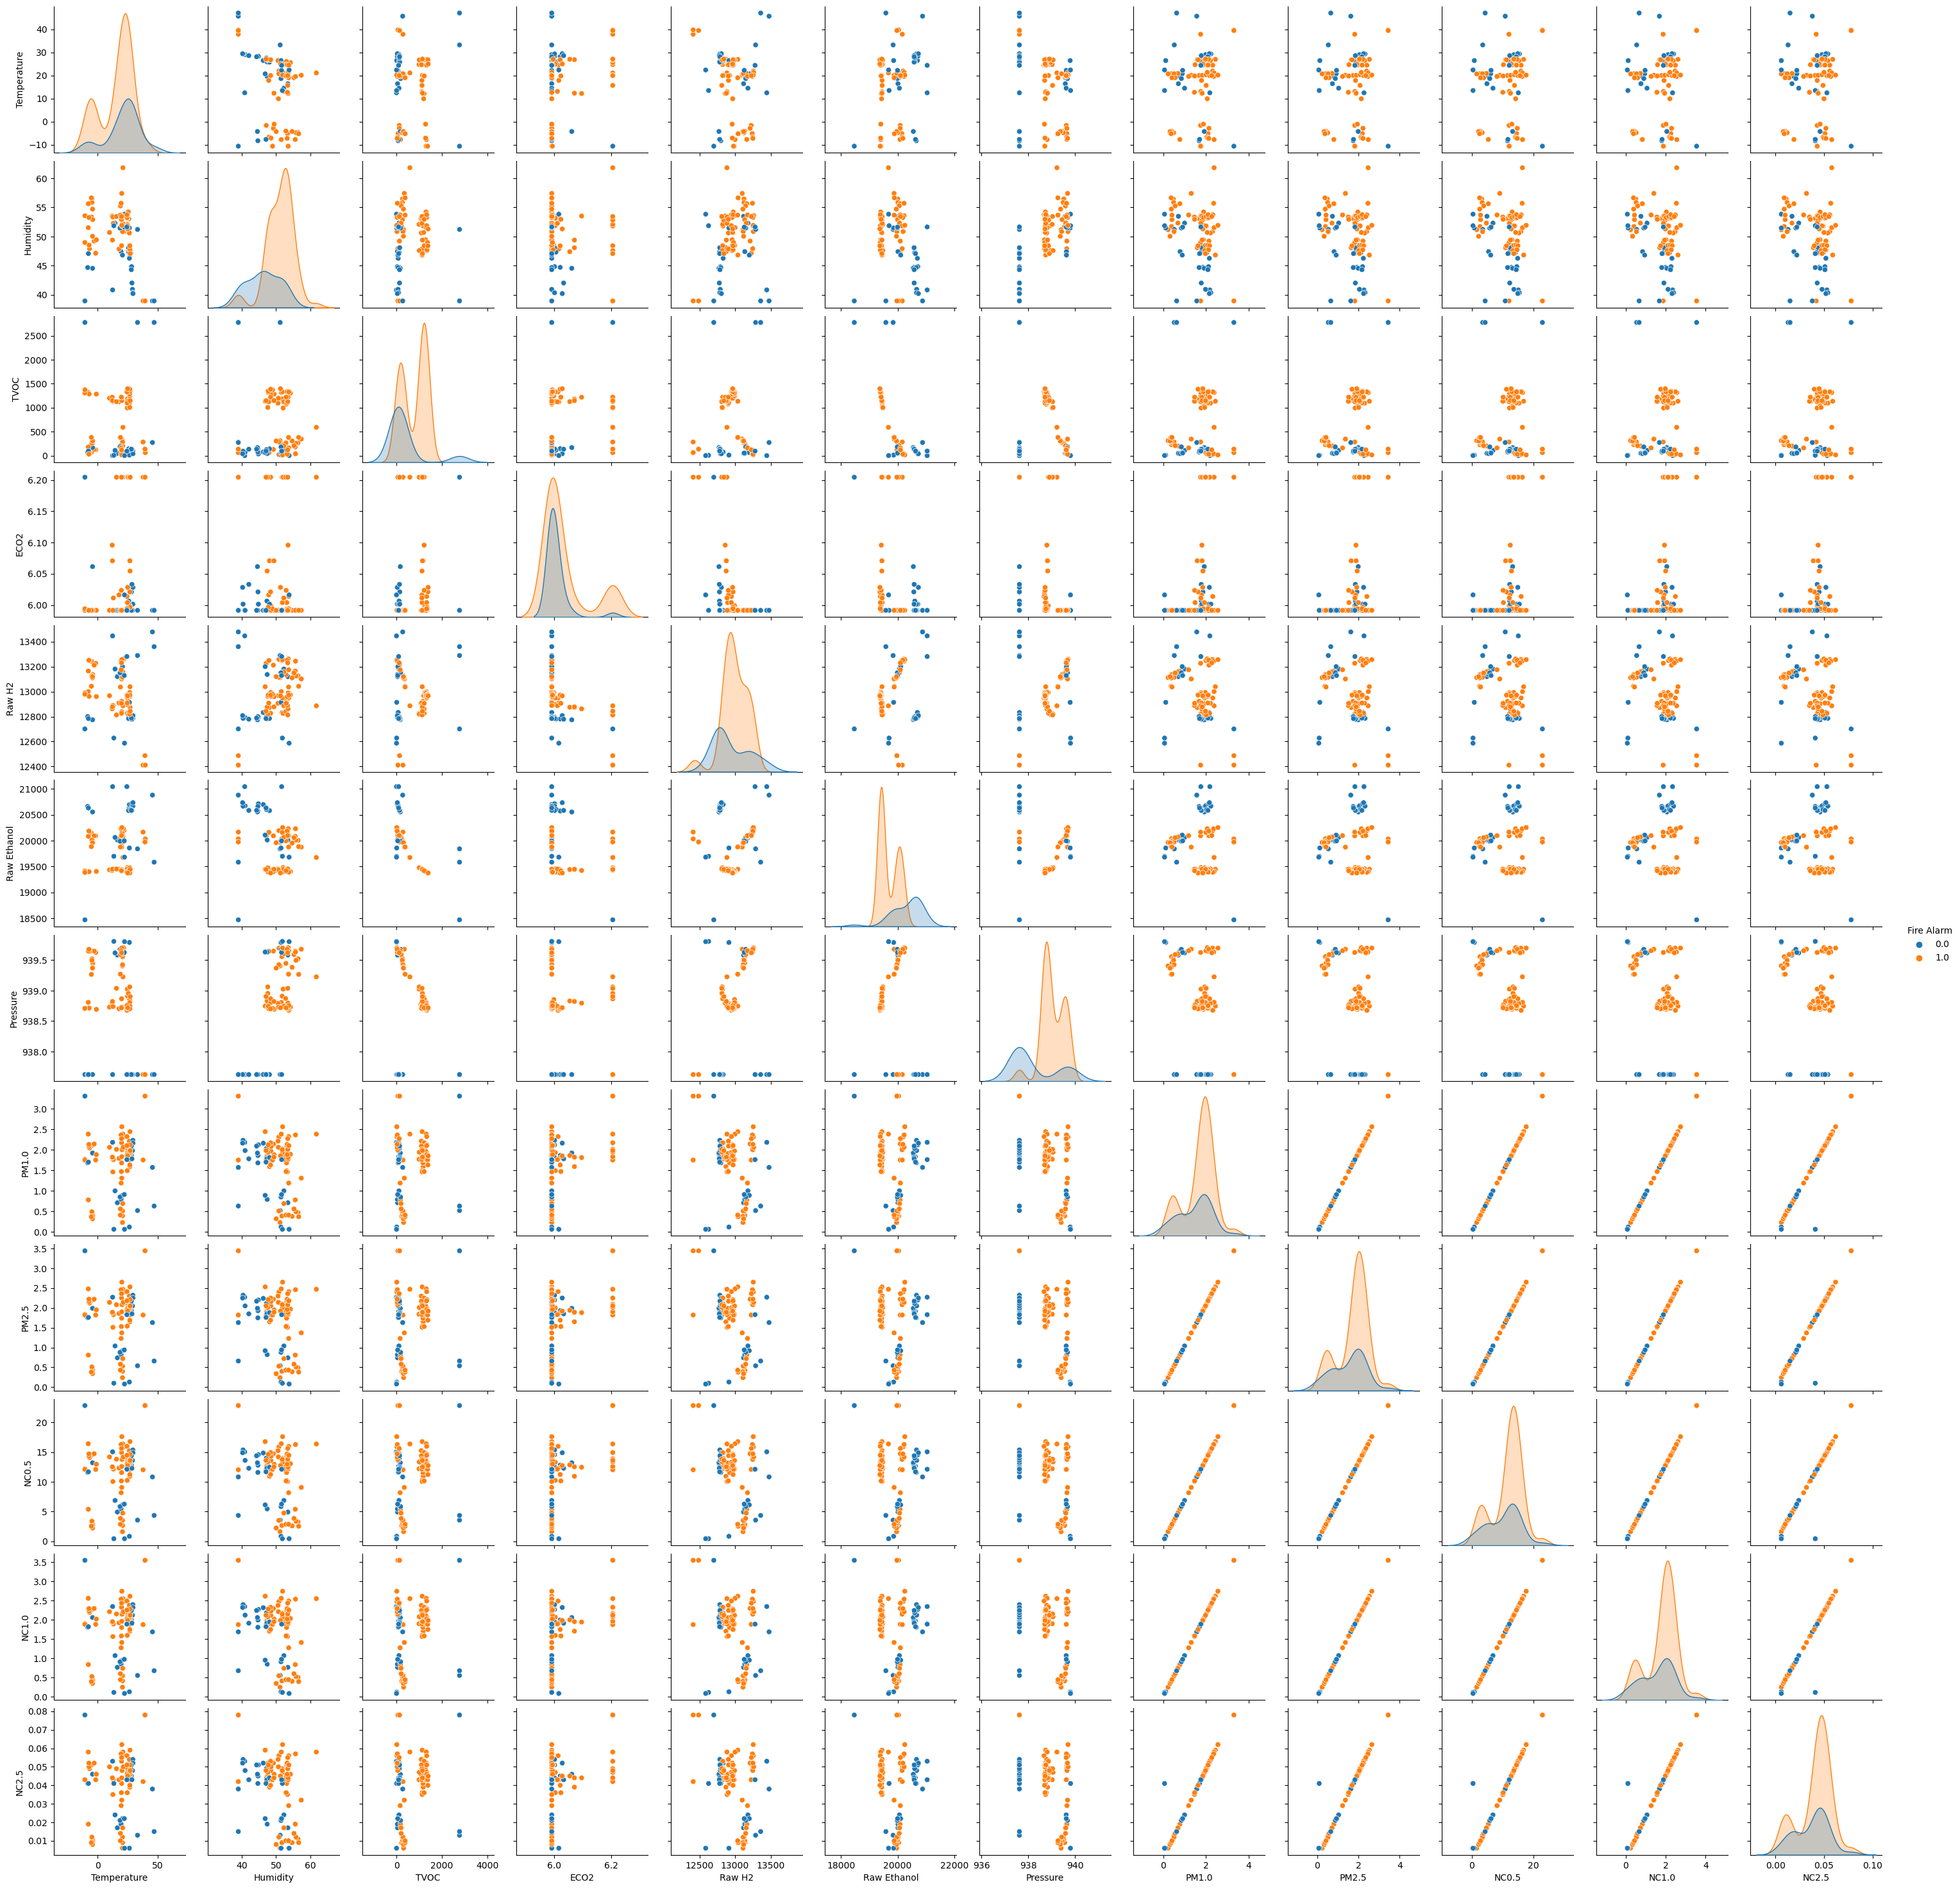

In [34]:
sns.pairplot(data=df.sample(100), hue="Fire Alarm")

## Feature Selection:

Text(0.5, 1.0, 'Correlation Map')

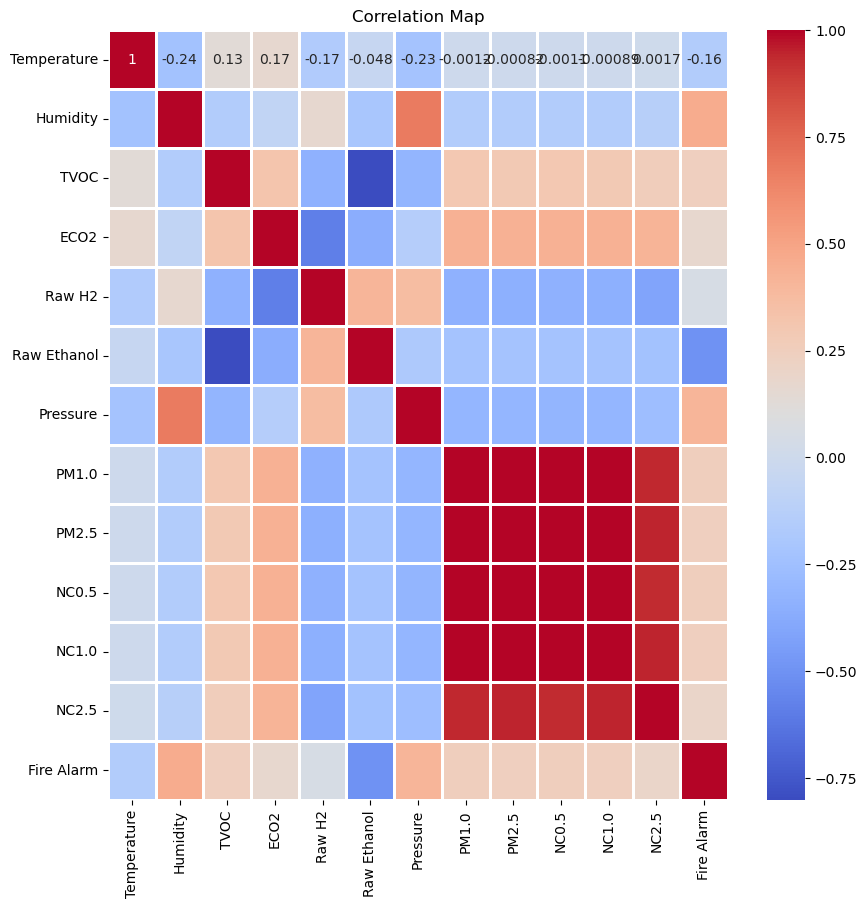

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(df.corr(),  cmap= "coolwarm", linewidths=1, annot=True)
plt.title("Correlation Map")


1. We can see the highly correlated features with Fire Alarm are Humidity, Pressure, Raw Ethanol. 

2. PM and NC are highly related with each other so we can remove some of them and only keep one to avoid overfitting the model. 

3. TVOC and Raw Ethanol are highly correlated so we can remove TVOC and keep Raw Ethanol

In [36]:
df.drop(columns=['PM2.5','NC0.5', 'NC1.0', 'NC2.5','TVOC'],inplace=True)

After dropping the highly correlated features:

<Axes: >

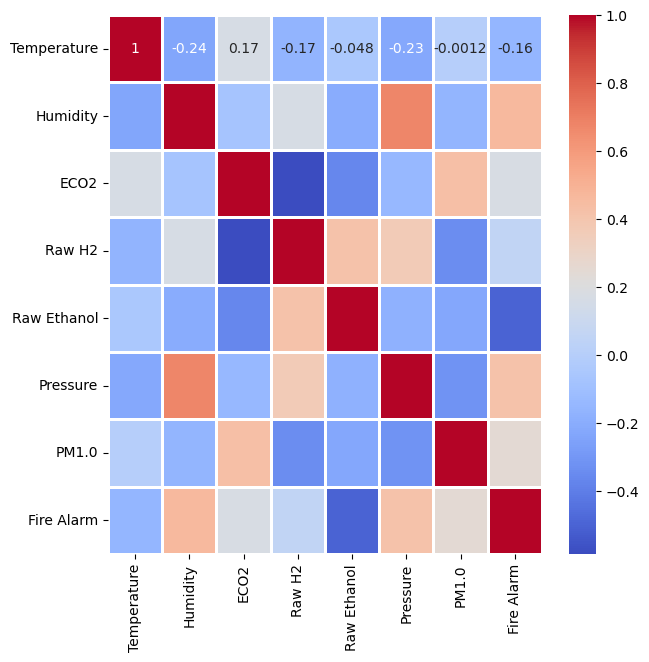

In [37]:
fig, ax = plt.subplots(figsize=(7, 7))

sns.heatmap(df.corr(),  cmap= "coolwarm", linewidths=1, annot=True)


# Model Building:

## Logistic Regression:

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix ,accuracy_score, classification_report

In [40]:
df.head()

Temperature  Humidity      ECO2   Raw H2  Raw Ethanol  Pressure  PM1.0  \
0       20.000     57.36  5.991465  12411.5      18520.0   939.735  0.065   
1       20.015     56.67  5.991465  12411.5      18651.0   939.744  0.065   
2       20.029     55.96  5.991465  12411.5      18764.0   939.738  0.065   
3       20.044     55.28  5.991465  12411.5      18849.0   939.736  0.065   
4       20.059     54.69  5.991465  12411.5      18921.0   939.744  0.065   

   Fire Alarm  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

In [41]:
x = df.drop(['Fire Alarm'],axis=1)
y = df['Fire Alarm']

In [42]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [43]:
x_train, x_test, y_trainlr, y_testlr = train_test_split(x_scaled, y, test_size=0.3, random_state=0)
print(x_train.shape)
print(x_test.shape)
print(y_trainlr.shape)
print(y_testlr.shape)



logreg = LogisticRegression()
logreg.fit(x_train, y_trainlr)

y_pred_lr_train = logreg.predict(x_train)
y_pred_lr_test = logreg.predict(x_test)

(43839, 7)
(18789, 7)
(43839,)
(18789,)


In [44]:
print('Training Accuracy :',accuracy_score(y_trainlr, y_pred_lr_train)*100)
print('Testing Accuracy :',accuracy_score(y_testlr, y_pred_lr_test)*100)

Training Accuracy : 89.30176327014759
Testing Accuracy : 89.22241737186651


In [45]:
cm=confusion_matrix(y_testlr, y_pred_lr_test)
print(cm)

[[ 3869  1540]
 [  485 12895]]


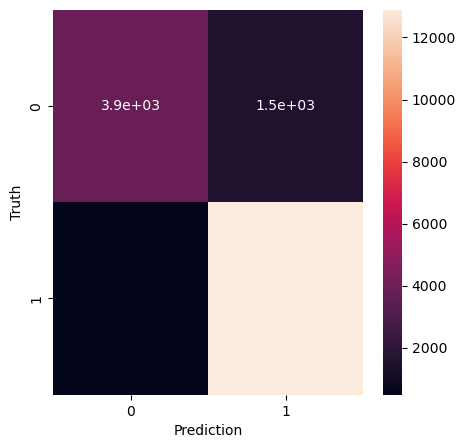

In [46]:
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True)
plt.ylabel("Truth")
plt.xlabel("Prediction")
plt.show()

In [47]:
print(classification_report(y_testlr, y_pred_lr_test))

              precision    recall  f1-score   support

         0.0       0.89      0.72      0.79      5409
         1.0       0.89      0.96      0.93     13380

    accuracy                           0.89     18789
   macro avg       0.89      0.84      0.86     18789
weighted avg       0.89      0.89      0.89     18789



## SVM: 

In [48]:
from sklearn.svm import SVC 
# from matplotlib import cm
from sklearn.model_selection import GridSearchCV

In [ ]:
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear', 'poly','rbf']}
# grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
# grid.fit(x_train,y_train)

In [ ]:
# grid.best_params_

In [ ]:
# grid.best_estimator_

In [50]:
#create SVC with rbf kernel with the best paramters taken from the gridsearch
x_train,x_test,y_trainsvm,y_testsvm=train_test_split(x,y,test_size=0.3,random_state=0) 
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train),columns = x_train.columns)
x_test= pd.DataFrame(scaler.transform(x_test),columns = x_test.columns)
model_rbf = SVC(kernel='rbf', gamma = 1, C = 100)
model_rbf.fit(x_train, y_trainsvm)

mean_accuracy_train = model_rbf.score(x_train, y_trainsvm)
mean_accuracy_test = model_rbf.score(x_test, y_testsvm)

print('Mean Accuracy on Train Data:', (mean_accuracy_train))
print('Mean Accuracy on Test Data:', (mean_accuracy_test))

Mean Accuracy on Train Data: 0.9997718926070394
Mean Accuracy on Test Data: 0.9992016605460642


In [51]:
grid_predictions = model_rbf.predict(x_test)
print(classification_report(y_testsvm,grid_predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5409
         1.0       1.00      1.00      1.00     13380

    accuracy                           1.00     18789
   macro avg       1.00      1.00      1.00     18789
weighted avg       1.00      1.00      1.00     18789



In [52]:
print(confusion_matrix(y_testsvm,grid_predictions))

[[ 5398    11]
 [    4 13376]]


## Random Forest:

In [53]:
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [54]:
rf=RandomForestClassifier(random_state=6)
x_train, x_test, y_trainrf, y_testrf = train_test_split(x, y, test_size=0.2, random_state=0)
#Train the model using the training sets
rf.fit(x_train,y_trainrf)


RandomForestClassifier(random_state=6)

In [55]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 6,
 'verbose': 0,
 'warm_start': False}

In [56]:
y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)
print('Accuracy Score on train data: ', metrics.accuracy_score(y_trainrf, y_train_pred))
print("Random Forest test Accuracy:", metrics.accuracy_score(y_testrf, y_test_pred))

Accuracy Score on train data:  1.0
Random Forest test Accuracy: 0.9996806642184257


In [57]:
RFCM = confusion_matrix(y_testrf, y_test_pred)
print(RFCM)

[[3621    4]
 [   0 8901]]


In [58]:
print(classification_report(y_testrf, y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3625
         1.0       1.00      1.00      1.00      8901

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526



#### Hyperparameter Tuning:

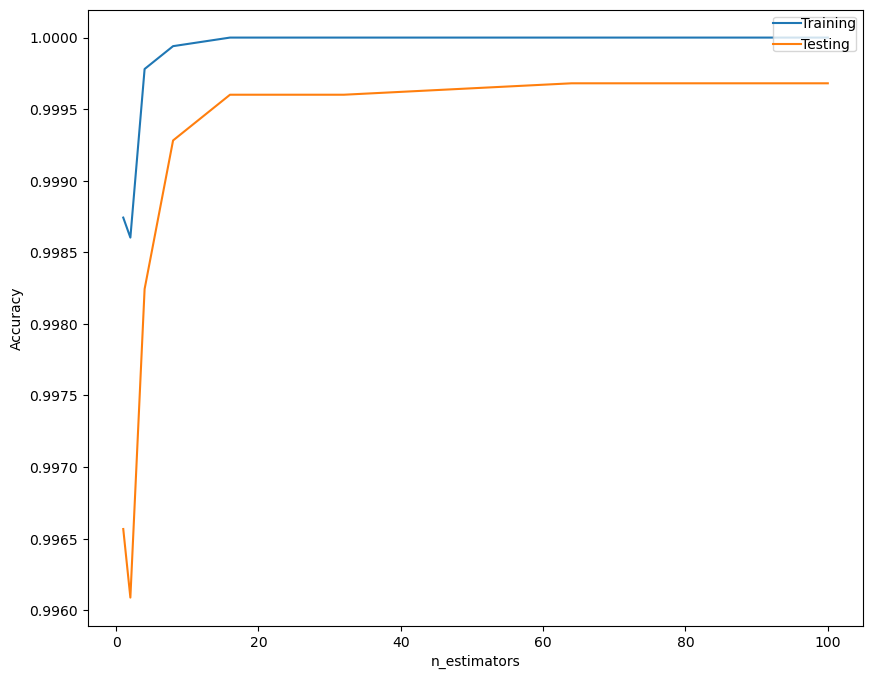

In [59]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100]
accuracy_train,accuracy_test=[],[]

for i in n_estimators:
    clf_rf=RandomForestClassifier(n_estimators=i, random_state=6)
    clf_rf.fit(x_train,y_trainrf)
    y_train_pred = clf_rf.predict(x_train)
    y_test_pred = clf_rf.predict(x_test)
    
    accuracy_train.append(metrics.accuracy_score(y_trainrf, y_train_pred))
    accuracy_test.append(metrics.accuracy_score(y_testrf, y_test_pred))

ax= plt.figure(figsize=(10, 8))
plt.plot(n_estimators,accuracy_train)
plt.plot(n_estimators,accuracy_test)
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.legend(['Training', 'Testing'],loc='upper right', borderpad=0, handletextpad=0) 
plt.show()


We can see that the n_estimators that have the best accuracy is 32

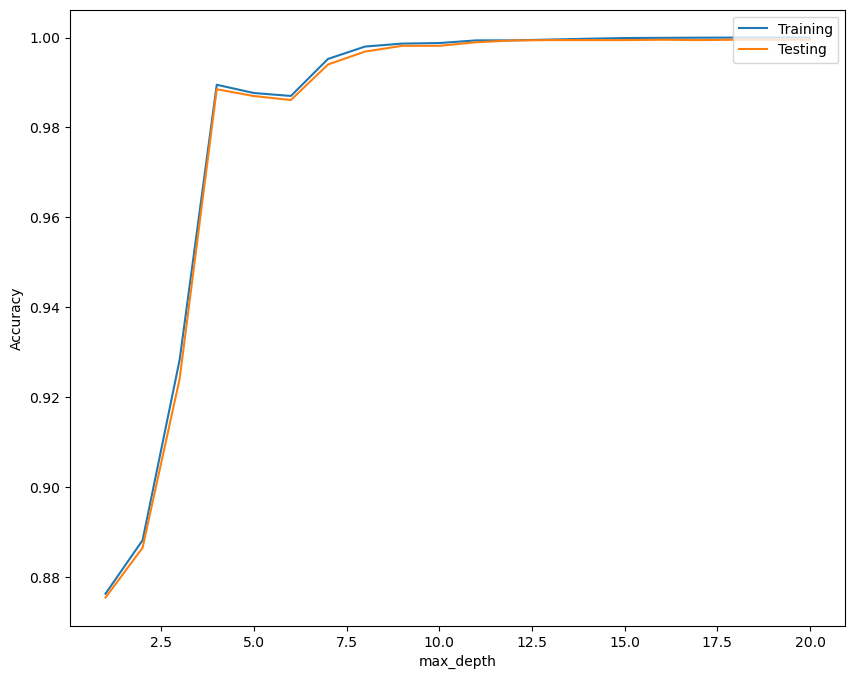

In [60]:
max_depth = np.linspace(1,20,20,dtype='int32')
accuracy_train,accuracy_test=[],[]

for i in max_depth:
    clf_rf=RandomForestClassifier(max_depth=i, random_state=6)
    clf_rf.fit(x_train,y_trainrf)
    y_train_pred = clf_rf.predict(x_train)
    y_test_pred = clf_rf.predict(x_test)
    
    accuracy_train.append(metrics.accuracy_score(y_trainrf, y_train_pred))
    accuracy_test.append(metrics.accuracy_score(y_testrf, y_test_pred))

ax= plt.figure(figsize=(10, 8))
plt.plot(max_depth,accuracy_train)
plt.plot(max_depth,accuracy_test)
plt.ylabel('Accuracy')
plt.xlabel('max_depth')
plt.legend(['Training', 'Testing'],loc='upper right') 
plt.show()

The best max_depth is around 10

Text(0.5, 1.0, 'Visualizing Important Features')

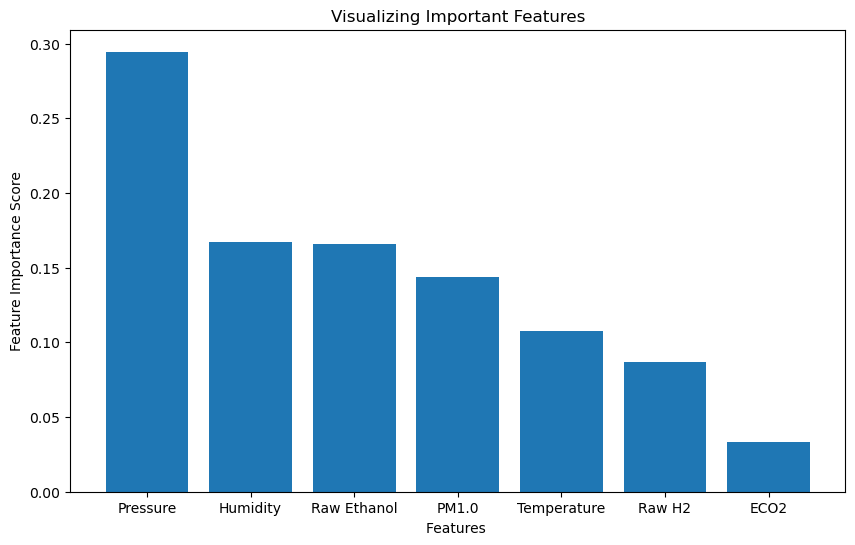

In [61]:
feature_imp = pd.Series(rf.feature_importances_, index=x.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.bar(feature_imp.index,feature_imp)

# Add labels to your graph
plt.xlabel('Features ')
plt.ylabel('Feature Importance Score')
plt.title("Visualizing Important Features")

In [62]:
new_data = df.drop("ECO2", axis=1) # remove the low important feature from the dataset

In [63]:
X_train, X_test, y_newtrain, y_newtest = train_test_split(new_data, y, test_size=0.3)
rf = RandomForestClassifier(n_estimators=32,max_depth=10, random_state=6)

rf.fit(X_train, y_newtrain)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print('Accuracy Score on train data: ', metrics.accuracy_score(y_newtrain, y_train_pred))
print("Random Forest test Accuracy:", metrics.accuracy_score(y_newtest, y_test_pred))

Accuracy Score on train data:  1.0
Random Forest test Accuracy: 1.0


In [64]:
RFCM = confusion_matrix(y_newtest, y_test_pred)
print(RFCM)

[[ 5437     0]
 [    0 13352]]


In [65]:
def visualise_tree(tree_to_print):
    plt.figure()
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=800)
    tree.plot_tree(tree_to_print,
               feature_names = x.columns.tolist(),
               class_names=['Fire','No Fire'], 
               filled = True,
              rounded=True)
    plt.show()

<Figure size 640x480 with 0 Axes>

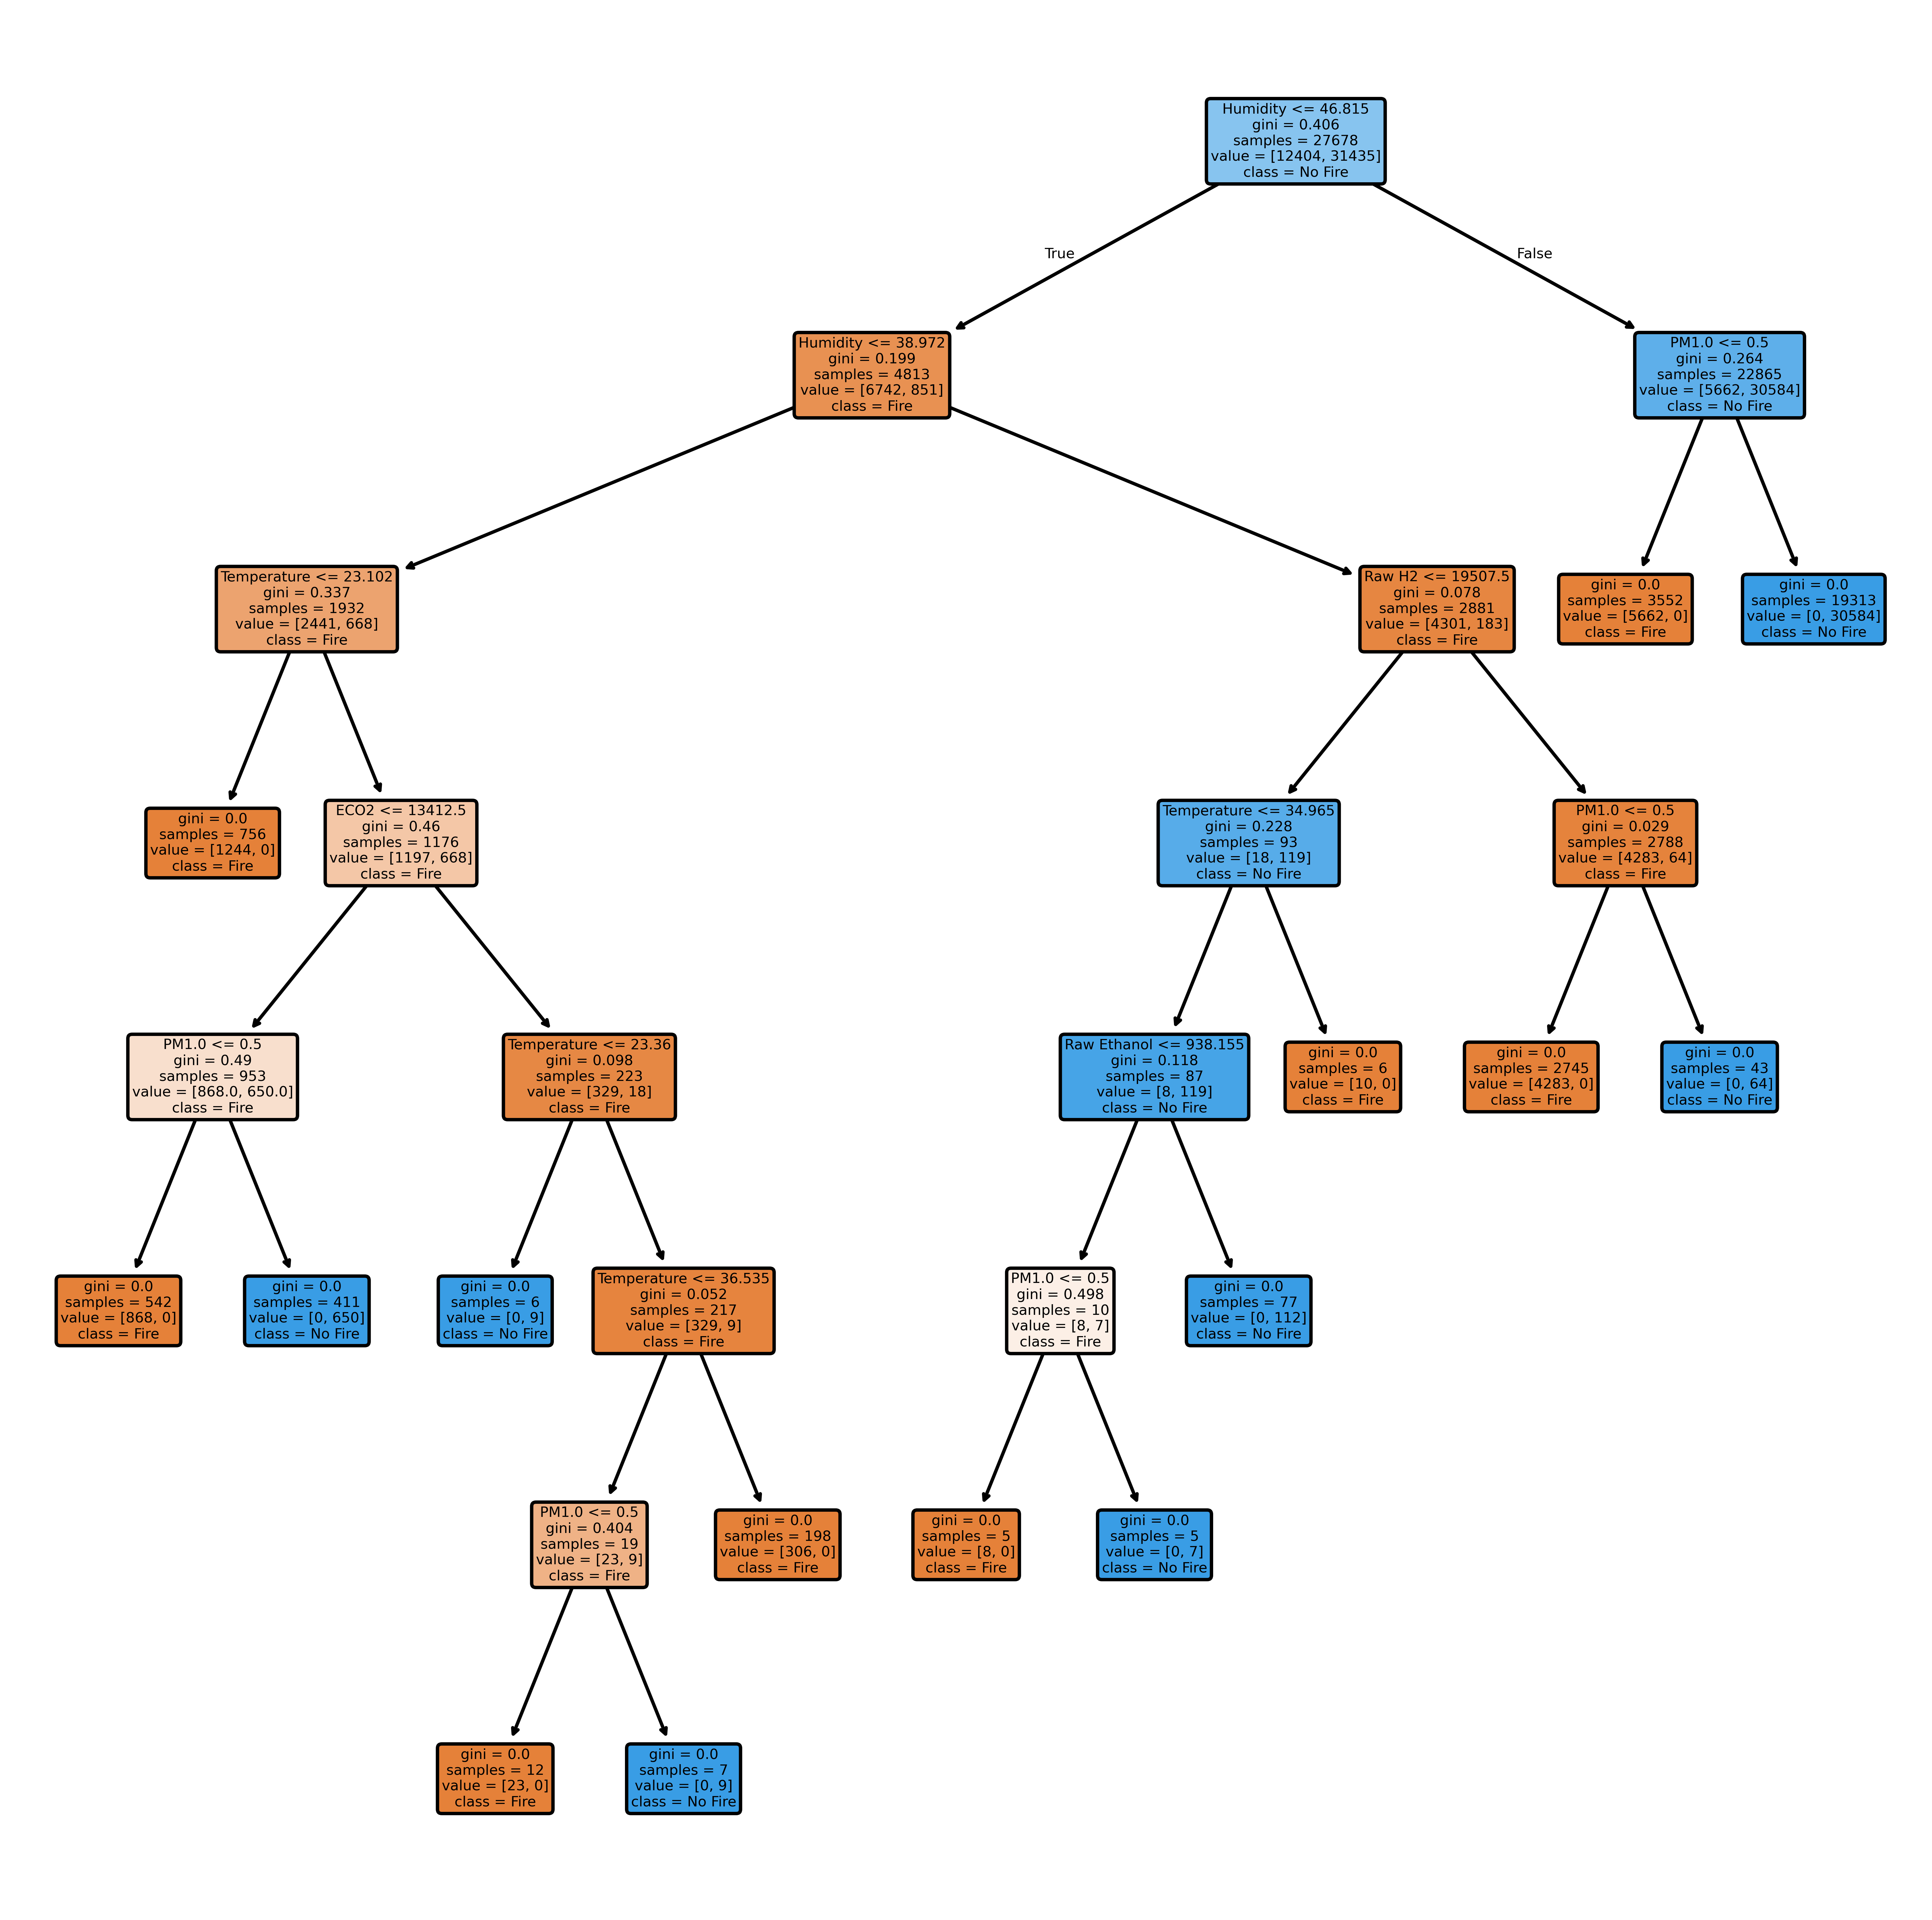

In [66]:
visualise_tree(rf.estimators_[10])

# Final Results:

### Logistic Regression:

In [67]:
print('Logistic Regression Training Accuracy :',accuracy_score(y_trainlr, y_pred_lr_train)*100)
print('Logistic Regression Testing Accuracy :',accuracy_score(y_testlr, y_pred_lr_test)*100)

Logistic Regression Training Accuracy : 89.30176327014759
Logistic Regression Testing Accuracy : 89.22241737186651


In [68]:
print(classification_report(y_testlr, y_pred_lr_test))

              precision    recall  f1-score   support

         0.0       0.89      0.72      0.79      5409
         1.0       0.89      0.96      0.93     13380

    accuracy                           0.89     18789
   macro avg       0.89      0.84      0.86     18789
weighted avg       0.89      0.89      0.89     18789



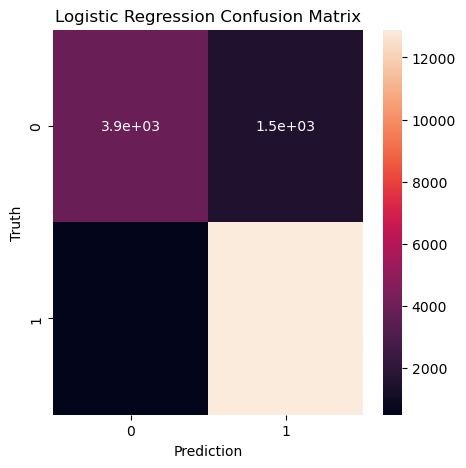

In [69]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_testlr,y_pred_lr_test),annot=True)
plt.title("Logistic Regression Confusion Matrix")
plt.ylabel("Truth")
plt.xlabel("Prediction")
plt.show()

### SVM:

In [70]:
print('SVM Accuracy on Train Data:', (mean_accuracy_train)*100)
print('SVM Accuracy on Test Data:', (mean_accuracy_test)*100)

SVM Accuracy on Train Data: 99.97718926070394
SVM Accuracy on Test Data: 99.92016605460641


In [71]:
print(classification_report(y_testsvm,grid_predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5409
         1.0       1.00      1.00      1.00     13380

    accuracy                           1.00     18789
   macro avg       1.00      1.00      1.00     18789
weighted avg       1.00      1.00      1.00     18789



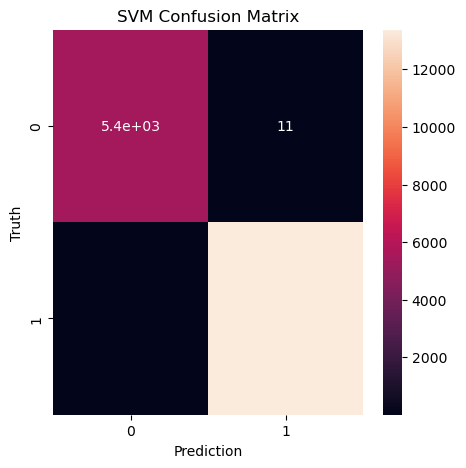

In [72]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_testsvm,grid_predictions),annot=True)
plt.title("SVM Confusion Matrix")
plt.ylabel("Truth")
plt.xlabel("Prediction")
plt.show()

### Random Forest:

In [73]:
print('Random Forest Accuracy on Train Data:', metrics.accuracy_score(y_newtrain, y_train_pred)*100)
print("Random Forest Accuracy on Train Data: ", metrics.accuracy_score(y_newtest, y_test_pred)*100)

Random Forest Accuracy on Train Data: 100.0
Random Forest Accuracy on Train Data:  100.0


In [74]:
print(classification_report(y_newtest,y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5437
         1.0       1.00      1.00      1.00     13352

    accuracy                           1.00     18789
   macro avg       1.00      1.00      1.00     18789
weighted avg       1.00      1.00      1.00     18789



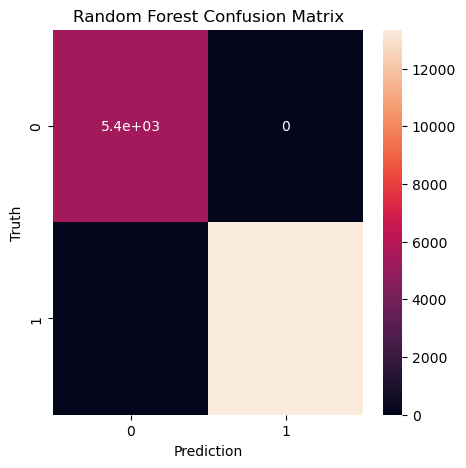

In [75]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_newtest,y_test_pred),annot=True)
plt.title("Random Forest Confusion Matrix")
plt.ylabel("Truth")
plt.xlabel("Prediction")
plt.show()

### Final Results:

In [76]:
print('Logistic Regression Training Accuracy :',round(accuracy_score(y_trainlr, y_pred_lr_train)*100,3))
print('Logistic Regression Testing Accuracy :',round(accuracy_score(y_testlr, y_pred_lr_test)*100,3))
print('')
print('SVM Accuracy on Train Data:', round((mean_accuracy_train)*100,3))
print('SVM Accuracy on Test Data:', round((mean_accuracy_test)*100,3))
print('')
print('Random Forest Accuracy on Train Data:', metrics.accuracy_score(y_newtrain, y_train_pred)*100)
print("Random Forest Accuracy on Train Data: ", metrics.accuracy_score(y_newtest, y_test_pred)*100)

Logistic Regression Training Accuracy : 89.302
Logistic Regression Testing Accuracy : 89.222

SVM Accuracy on Train Data: 99.977
SVM Accuracy on Test Data: 99.92

Random Forest Accuracy on Train Data: 100.0
Random Forest Accuracy on Train Data:  100.0


1. Logistic Regression: gave the lowest accuracy at 89% probably because it assumed the data is linearly seperable when in reality not all the data was.

    Advantages: Simple and least Memory intensive model.
    
    Disadvantages: The lowest accuracy at 89% as it assumes linear relationship between the features and target even when there isn't
2. SVM:

    Advantages: 99.963% accuracy on test set and was able to handle linear and non linear features

    Disadvantages: Memory intensive, took 76 minutes to get the best hyperparameters and kernel.

3. Random Forest:

    Advantages: Highest accuracy (100%) and less computationally intensive than SVM 

    Disadvantages: May have overfit the model.

Winner is Random Forest!

# Credits:

1. Dataset: https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset/data

2. The data is collected by Stefan Blattmann in his project Real-time Smoke Detection with AI-based Sensor Fusion. https://www.hackster.io/stefanblattmann/real-time-smoke-detection-with-ai-based-sensor-fusion-1086e6
3. Author's GitHub : https://github.com/Blatts01
